## Hyper-parameter search - Optuna
1. Open hyper-parameter search.ipynb 
2. Execute cells in sequence until "optimization" cell

## Training parameters
Defining at the `objective` function.  
1. bounds: Deciding the upper and lower bounds of each transformation.  
2. validation loss: The combination of classification and L2 distance loss, Ex: Focal+Huber or Softmax+Center.  
3. trial.report: Reporting the validation loss of each epoch in each trial, only report the value produced in the first training.  

## Optuna parameters
`storage` is the saved db path.  

`sampler`: TPE sampler
1.  n_startup_trials: Start to use TPE after this number of trials.  
2.  n_ei_candidates: Sample times to calculate EI.  
3.  gamma: Parameter of the TPE definition for choosing quantity of records to form probabiltiy distribution of L.  

`pruner`: MedianPruner
1. n_startup_trials: Quantity of trials not to prune.  
2. n_warmup_steps: Quantity of epoch not to prune.  

Reference: https://optuna.readthedocs.io/en/stable/reference/index.html

In [4]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timm
import cv2
import math
import torch.nn.functional as F
from torch.autograd import Variable
import random
plt.style.use("default")
    
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., amplitude=(0,25)):
        self.std = std
        self.mean = mean
        self.amplitude = amplitude
        
    def __call__(self, img):
        img_arr = np.asarray(img)
        gauss = np.random.normal(self.mean,self.std,img_arr.shape) * random.randint(*self.amplitude)
        img = img_arr + gauss
        img[img>255] = 255
        return Image.fromarray(img.astype("uint8")).convert("RGB")
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

batch_size_train = 32
batch_size_test = 32
image_size = 224
trainingTransform = transforms.Compose([
    transforms.ToPILImage(),
    # CLAHE(),
    transforms.RandomApply([AddGaussianNoise(0 , 1,(0,25))], p=0.6),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.9, contrast=0.9, saturation=0.9)], p=0.9),
    transforms.RandomApply([transforms.ColorJitter(hue=0.15)], p=0.6),
    transforms.RandomAdjustSharpness(1.5, p=0.6),
    transforms.RandomApply([transforms.RandomChoice([transforms.GaussianBlur(3, sigma=(0.1, 4)), 
                                                     transforms.GaussianBlur(5, sigma=(0.1, 4))])], p=0.6),
    transforms.RandomApply([transforms.RandomAffine(degrees=(-5,5), translate=(0.03, 0.03), scale=(0.98, 1.02))], p=0.5),
    transforms.Resize(image_size),
    transforms.ToTensor(),
])
testingTransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

In [5]:
## Tongji dataset
# flexibly spliting support set and query set
class TongjiFewShotDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            self.session1 = 10 if num_samples > 10 else num_samples
            self.session2 = num_samples - self.session1
            if mode == "probe":
                self.session1, self.session2 = self.session2, self.session1
                self.session1 = range(10-self.session1, 10)
                self.session2 = range(10-self.session2, 10)
            else:
                self.session1 = range(self.session1)
                self.session2 = range(self.session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(self.fnames[idx])
        img = np.asarray(img)
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 補足3個channel
        # img = img.repeat(3,1,1)
        # 圖片相對應的 label
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class TongjiRotationCopyDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            self.session1 = 10 if num_samples > 10 else num_samples
            self.session2 = num_samples - self.session1
            if mode == "probe":
                self.session1, self.session2 = self.session2, self.session1
                self.session1 = range(10-self.session1, 10)
                self.session2 = range(10-self.session2, 10)
            else:
                self.session1 = range(self.session1)
                self.session2 = range(self.session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        i = idx % (len(self.indices) * self.num_samples)
        quotient = int(idx / (len(self.indices) * self.num_samples))
        img = Image.open(self.fnames[i])
        img = np.asarray(img)
        if quotient > 0:
            img = np.rot90(img, quotient, (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        label = self.labels[i]
        return img, label + 600 * quotient
    
    def __len__(self):
        return len(self.fnames)*4

In [6]:
## PolyU dataset    
# flexibly spliting support set and query set
class PolyUFewShotDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        if num_samples > 12:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 6 if num_samples > 6 else num_samples
            session2 = num_samples - session1
            if mode == "probe":
                session1, session2 = session2, session1
                self.session1 = range(6-session1, 6)
                self.session2 = range(6-session2, 6)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 1, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
            # get images from session2
            for i in self.session2:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 2, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        imgs = []
        for i in self.fnames[idx]:
            imgs.append(Image.open(i))
        img = np.dstack(imgs)
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class PolyURotationCopyDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 12:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 6 if num_samples > 6 else num_samples
            session2 = num_samples - session1
            if mode == "probe":
                session1, session2 = session2, session1
                self.session1 = range(6-session1, 6)
                self.session2 = range(6-session2, 6)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 1, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
            # get images from session2
            for i in self.session2:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 2, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        imgs = []
        i = idx % (len(self.indices) * self.num_samples)
        quotient = int(idx / (len(self.indices) * self.num_samples))
        for path in self.fnames[i]:
            imgs.append(Image.open(path))
        img = np.dstack(imgs)
        if quotient > 0:
            img = np.rot90(img, quotient, (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        label = self.labels[i]
        return img, label + 500 * quotient
    
    def __len__(self):
        return len(self.fnames*4)

In [7]:
## MPD dataset
# contain all data of specific phone
class MPDTrainingDataset(Dataset):
    '''
    all images of selected indices 
    '''
    def __init__(self, root, indices, phone, transforms):
        self.root = root
        self.indices = indices
        self.phone = phone
        self.transforms = transforms

        self.fnames = []
        self.labels = []
        for c in self.indices:
            for i in range(10):
                for p in self.phone:
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, p, "l", i+1))) # 左手session1
                    self.labels.append(2*c)
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, p, "l", i+1))) # 左手session2
                    self.labels.append(2*c)
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, p, "r", i+1))) # 右手session1
                    self.labels.append(2*c+1)
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, p, "r", i+1))) # 右手session2
                    self.labels.append(2*c+1)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)

# flexibly spliting support set and query set
class MPDFewShotDataset(Dataset):
    '''
    can only use for single phone
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 40:
            raise BaseException("Number of samples larger than the limit")
        else:
            if mode == "probe": # count backward
                self.session = [2,1]
                self.phone = "mh"
                self.samples = range(9, -1, -1)
            else:
                self.session = [1,2]
                self.phone = "hm"
                self.samples = range(10)

        
        self.fnames = []
        self.labels = []
        for c in self.indices:
            count = 0
            for s in self.session:
                for i in self.samples:
                    for p in self.phone:
                        if count >= self.num_samples:
                            break
                        self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, s, p, "l", i+1))) # 左手session1
                        self.labels.append(2*c)
                        self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, s, p, "r", i+1))) # 右手session1
                        self.labels.append(2*c+1)
                        count += 1
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
class MPDFewShotSingleDataset(Dataset):
    '''
    can only use for single phone
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, phone, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.phone = phone
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 10 if num_samples > 10 else num_samples
            session2 = num_samples - session1
            if mode == "probe": # count backward
                session1, session2 = session2, session1
                self.session1 = range(10-session1, 10)
                self.session2 = range(10-session2, 10)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        
        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "l", i+1))) # 左手session1
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "r", i+1))) # 右手session1
                self.labels.append(2*c+1)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "l", i+1))) # 左手session2
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "r", i+1))) # 右手session2
                self.labels.append(2*c+1)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = np.asarray(img)
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)

In [8]:
## Loss functions
def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output

class CurricularFace(nn.Module):
    def __init__(self, in_features, out_features, s = 64., m = 0.5, centers=False):
        super(CurricularFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.m = m
        self.s = s
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.threshold = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('t', torch.zeros(1))
        nn.init.normal_(self.weight, std=0.01)

    def classify(self, x, centers=None):   
        weights = self.weight
        if torch.is_tensor(centers):
            weights = centers     
        logits = F.linear(F.normalize(x), F.normalize(weights))
        return self.s * logits

    def forward(self, embbedings, label, centers=None):
        weights = self.weight
        if torch.is_tensor(centers) and centers.shape == self.weight.shape:
            weights = centers
        
        embbedings = l2_norm(embbedings, axis = 1)
        kernel_norm = l2_norm(weights, axis = 1)
        cos_theta = torch.mm(embbedings, torch.transpose(kernel_norm, 0, 1))
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        with torch.no_grad():
            origin_cos = cos_theta.clone()
        target_logit = cos_theta[torch.arange(0, embbedings.size(0)), label].view(-1, 1)

        sin_theta = torch.sqrt(1.0 - torch.pow(target_logit, 2))
        cos_theta_m = target_logit * self.cos_m - sin_theta * self.sin_m #cos(target+margin)
        mask = cos_theta > cos_theta_m
        final_target_logit = torch.where(target_logit > self.threshold, cos_theta_m, target_logit - self.mm)

        hard_example = cos_theta[mask]
        with torch.no_grad():
            self.t = target_logit.mean() * 0.01 + (1 - 0.01) * self.t
        cos_theta[mask] = hard_example * (self.t + hard_example)
        cos_theta.scatter_(1, label.view(-1, 1).long(), final_target_logit)
        margin_output = cos_theta * self.s
        original_logits = origin_cos * self.s
        return margin_output, original_logits

class ArcFace(torch.nn.Module):
    """ ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
    """
    def __init__(self, in_features=128, out_features=10575, s=32.0, m=0.50, easy_margin=False, centers=False):
        super(ArcFace, self).__init__()
        self.in_feature = in_features
        self.out_feature = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        # make the function cos(theta+m) monotonic decreasing while theta in [0°,180°]
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, x, label):
        # cos(theta)
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        with torch.no_grad():
            origin_cos = cosine.clone()
        # cos(theta + m)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)

        #one_hot = torch.zeros(cosine.size(), device='cuda' if torch.cuda.is_available() else 'cpu')
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output = output * self.s
        margin_output = origin_cos * self.s
        return margin_output, output
    
class LMCL(nn.Module):
    def __init__(self, in_features=128, out_features=600, s=30.0, m=0.65, centers=False):
        super(LMCL, self).__init__()
        self.in_feature = in_features
        self.out_feature = out_features
        self.s = s
        self.m = m
        if torch.is_tensor(centers) and centers.shape == (out_features, in_features):
            self.weight = nn.Parameter(centers)
        else:
            self.weight = nn.Parameter(torch.randn(out_features, in_features))
            # nn.init.xavier_uniform_(self.weight)
            # nn.init.kaiming_uniform_(self.weight)
            # nn.init.normal_(self.weight, std=0.01)

    def classify(self, x, centers=None):   
        weights = self.weight
        if torch.is_tensor(centers):
            weights = centers     
        logits = F.linear(F.normalize(x), F.normalize(weights))
        return self.s * logits
    
    def forward(self, x, label, centers=None):
        weights = self.weight
        if torch.is_tensor(centers) and centers.shape == self.weight.shape:
            weights = centers
        # else:
        #     weights = self.centers()
        cosine = F.linear(F.normalize(x), F.normalize(weights))
        with torch.no_grad():
            origin_cos = cosine.clone()
            
        # one_hot = torch.zeros(cosine.size(), device='cuda' if torch.cuda.is_available() else 'cpu')
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        margin_output = self.s * (cosine - one_hot * self.m)
        original_logits = self.s * origin_cos
        return margin_output, original_logits
    
class CenterLoss(nn.Module):
    def __init__(self):
        super(CenterLoss, self).__init__()

    def forward(self, feats, label, centers):
        center = centers[label]
        dist = (feats-center).pow(2).sum(dim=-1) / 2
        loss = torch.clamp(dist, min=1e-12, max=1e+12).mean(dim=-1)
        return loss

class CenterHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(CenterHuberLoss, self).__init__()
        self.HuberLoss = nn.HuberLoss(delta=delta)
        self.delta = delta

    def forward(self, feats, label, centers):
        center = centers[label]
        # dist = (feats-center).pow(2).sum(dim=-1) / 2
        dist = self.HuberLoss(feats, center)
        loss = torch.clamp(dist, min=1e-12, max=1e+12).mean(dim=-1)
        return loss
    
class FocalLoss(nn.Module):
    def __init__(self, gamma = 2, eps = 1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [9]:
dataset_params = {}
dataset_params["Tongji"] = ["../data/TongJi/palmprint/ROI_RGB", 600]
dataset_params["Tongji_JPG"] = ["../data/TongJi/palmprint/ROI_JPG", 600]
dataset_params["PolyU"] = ["../data/PolyU", 500]
dataset_params["PolyU_JPG"] = ["../data/PolyU/ROI_JPG", 500]
dataset_params["MPD"] = ["../data/MPD/ROI", 200]
dataset_params["MPD_h"] = dataset_params["MPD_m"] = dataset_params["MPD"]

def buildDatasets(dataset, trainingTransform, testingTransform, shot=5, val_ratio=0.2, test_ratio=0.2, indices=False):
    if indices:
        training_class_indices, testing_class_indices = indices
    elif test_ratio == 0:
        training_class_indices = range(dataset_params[dataset][1])
        testing_class_indices = range(dataset_params[dataset][1])
    else:
        training_class_indices, testing_class_indices = data.random_split(
            range(dataset_params[dataset][1]), [int(dataset_params[dataset][1]*(1-test_ratio)), int(dataset_params[dataset][1]*test_ratio)])
    
    if(dataset == "Tongji"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = TongjiFewShotDataset(dataset_params[dataset][0], training_class_indices, 20, "gallery", trainingTransform)
        validationDataset = TongjiFewShotDataset(dataset_params[dataset][0], training_class_indices, 20, "probe", testingTransform)
        galleryDataset = TongjiFewShotDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
        probeDataset = TongjiFewShotDataset(dataset_params[dataset][0], testing_class_indices, 20-shot, "probe", testingTransform)
    elif(dataset == "PolyU"):
        num_val_samples = int(12*val_ratio)
        trainingDataset = PolyUFewShotDataset(dataset_params[dataset][0], training_class_indices, 12, "gallery", trainingTransform)
        validationDataset = PolyUFewShotDataset(dataset_params[dataset][0], training_class_indices, 12, "probe", testingTransform)
        galleryDataset = PolyUFewShotDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
        probeDataset = PolyUFewShotDataset(dataset_params[dataset][0], testing_class_indices, 12-shot, "probe", testingTransform)
    elif(dataset == "MPD_h"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "h", 20, "gallery", trainingTransform)
        validationDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "h", 20, "probe", testingTransform)
        galleryDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "h", shot, "gallery", testingTransform)
        probeDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "h", 20-shot, "probe", testingTransform)
    elif(dataset == "MPD_m"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "m", 20, "gallery", trainingTransform)
        validationDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "m", 20, "probe", testingTransform)
        galleryDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "m", shot, "gallery", testingTransform)
        probeDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "m", 20-shot, "probe", testingTransform)
    # elif(dataset == "MPD"):
    #     trainingDataset = MPDTrainingDataset(dataset_params[dataset][0], training_class_indices, "hm", trainingTransform)
    #     galleryDataset = MPDFewShotDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
    #     probeDataset = MPDFewShotDataset(dataset_params[dataset][0], testing_class_indices, 40-shot, "probe", testingTransform)
    else:
        print(dataset)
        
    return trainingDataset, validationDataset, galleryDataset, probeDataset, training_class_indices, testing_class_indices

def buildDataloaders(trainingDataset, validationDataset, galleryDataset, probeDataset, batch_size_train = 55, batch_size_test = 128):
    trainingDataloader = DataLoader(trainingDataset, batch_size=batch_size_train, shuffle=True)
    validationDataloader = DataLoader(validationDataset, batch_size=batch_size_test, shuffle=False)
    galleryDataloader = DataLoader(galleryDataset, batch_size=batch_size_test, shuffle=False)
    probeDataloader = DataLoader(probeDataset, batch_size=batch_size_test, shuffle=False)
    return trainingDataloader, validationDataloader, galleryDataloader, probeDataloader

In [10]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
def initModel(model_type, head_type, num_classes, feature_dim, loss_func, lamb, lr=0.01, l2=0, mm=0.9):
    if model_type == "ResNet20_basic":
        model = resnet20_basic(feature_dim)
    elif model_type == "ResNeSt26d_pretrained":
        model = timm.create_model('resnest26d', pretrained=True
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "Reduced_ResNeSt26d_pretrained":
        model = timm.create_model('resnest26d', pretrained=True)
        model.layer4 = Identity()
        model.fc = nn.Linear(1024, feature_dim) 
    elif model_type == "ResNeSt26d":
        model = timm.create_model('resnest26d')
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "ResNeSt14d_pretrained":
        model = timm.create_model('resnest14d', pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "ResNeSt50d_pretrained":
        model = timm.create_model('resnest50d', pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "Reduced_ResNeSt50d_pretrained":
        model = timm.create_model('resnest50d', pretrained=True)
        model.layer4 = Identity()
        model.fc = nn.Linear(1024, feature_dim)
    else:
        raise BaseException("Invalid model type")

    if head_type == "LMCL":
        head = LMCL(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.65, centers=False)
        # head = LMCL_loss(num_classes, feature_dim, s=30.00, m=0.65)
    elif head_type == "CurricularFace":
        head = CurricularFace(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.65, centers=False)
    elif head_type == "ArcFace":
        head = ArcFace(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.65, centers=False)
    else:
        raise BaseException("Invalid loss function type")
        
    if loss_func == "CE+Center":
        criterion = {"Softmax": nn.CrossEntropyLoss(), "CenterLoss": CenterLoss(), "Lambda": lamb}
    elif loss_func == "Focal+Center":
        criterion = {"Softmax": FocalLoss(gamma=2), "CenterLoss": CenterLoss(), "Lambda": lamb}
    elif loss_func == "Focal+Huber":
        criterion = {"Softmax": FocalLoss(gamma=2), "CenterLoss": CenterHuberLoss(delta=10), "Lambda": lamb}
    elif loss_func == "CE+Huber":
        criterion = {"Softmax": nn.CrossEntropyLoss(), "CenterLoss": CenterHuberLoss(delta=10), "Lambda": lamb}
    else:
        raise BaseException("Invalid loss function type")
    

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mm)
    optimizer4center = torch.optim.Adam(head.parameters(), lr=0.1, weight_decay=l2)
    return model, head, criterion, optimizer, optimizer4center

In [11]:
## initial dataset parameters
## dataset parameters
dataset_choices = ["PolyU","Tongji","MPD_h","MPD_m"]
dataset = dataset_choices[0]
val_ratio = 0
test_ratio = 0.1
shot = 5
num_classes_source = dataset_params[dataset][1]*2 if dataset.startswith("MPD") else dataset_params[dataset][1]
dataset_type = f'{dataset}' if test_ratio else f'{dataset}_full'

print("------ dataset parameters ------")
print("dataset: ", dataset)
print("val ratio: ", val_ratio)
print("test ratio: ", test_ratio)
print("number of shots: ", shot)

(trainingDataset_source, 
validationDataset_source, 
galleryDataset_source, 
probeDataset_source, 
training_class_indices_source, 
testing_class_indices_source) = buildDatasets(dataset, trainingTransform, testingTransform, shot, val_ratio, test_ratio)
trainingDataloader_source, validationDataloader_source, galleryDataloader_source, probeDataloader_source = buildDataloaders(
    trainingDataset_source, validationDataset_source, galleryDataset_source, probeDataset_source, batch_size_train = 32, batch_size_test = 128)
print("------ source dataset parameters ------")
print("training classes: ", len(training_class_indices_source))
print("testing classes: ", len(testing_class_indices_source))
print("training samples: ", len(trainingDataset_source))
print("validation samples: ", len(validationDataset_source))
print("gallery samples: ", len(galleryDataset_source))
print("probe samples: ", len(probeDataset_source))
print("------ end dataset parameters ------")

## target dataset parameters
dataset_choices = ["PolyU","Tongji","MPD_h","MPD_m"]
dataset_target = dataset_choices[2]
val_ratio = 0
test_ratio = 0.5
shot = 5
num_classes_target = dataset_params[dataset_target][1]*2 if dataset_target.startswith("MPD") else dataset_params[dataset_target][1]

print("------ dataset parameters ------")
print("dataset: ", dataset_target)
print("val ratio: ", val_ratio)
print("test ratio: ", test_ratio)
print("number of shots: ", shot)

(trainingDataset_target, 
validationDataset_target, 
galleryDataset_target, 
probeDataset_target, 
training_class_indices_target, 
testing_class_indices_target) = buildDatasets(dataset_target, trainingTransform, testingTransform, shot, val_ratio, test_ratio)
trainingDataloader_target, validationDataloader_target, galleryDataloader_target, probeDataloader_target = buildDataloaders(
    trainingDataset_target, validationDataset_target, galleryDataset_target, probeDataset_target, batch_size_train = 32, batch_size_test = 128)
print("------ target dataset parameters ------")
print("training classes: ", len(training_class_indices_target))
print("testing classes: ", len(testing_class_indices_target))
print("training samples: ", len(trainingDataset_target))
print("validation samples: ", len(validationDataset_target))
print("gallery samples: ", len(galleryDataset_target))
print("probe samples: ", len(probeDataset_target))
print("------ end dataset parameters ------")

## initial model parameters
epoch = 0
feature_dim = 128
# model type
# model_type = "ResNeSt26d"
# model_type = "ResNeSt26d_pretrained"
# model_type = "Reduced_ResNeSt26d_pretrained"
# model_type = "ResNeSt50d_pretrained"
model_type = "Reduced_ResNeSt50d_pretrained"

## loss functinos
head_type = "LMCL"
# head_type = "CurricularFace"
# head_type = "ArcFace"


# loss_func = "CE+Center"
# loss_func = "Focal+Center"
loss_func = "Focal+Huber"
# loss_func = "CE+Huber"
lamb = 1

# optimzer
lr = 0.001
mm = 0.9
l2 = 0

model, head, criterion, optimizer, optimzer4center = initModel(
    model_type, head_type, num_classes_source, feature_dim, loss_func, lamb, lr, l2, mm)
prefix = "{}-{}s-{}-{}emb-{}-{}-{}l-{}lr-{}mm-{}l2".format(dataset_type, shot, model_type, feature_dim, head_type, loss_func, lamb, lr, mm, l2)

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("------ model parameters ------")
print("model type: ", model_type)
print("loss function: ", loss_func, ", lambda: ", lamb)
print("learning rate: ", lr, ", L2 Norm(weight decay): ", l2, ", momentum: ", mm)
print("sameple model name: {}-{}e.pt".format(prefix, epoch))
print('parameter total:{}, trainable:{}'.format(total, trainable))
print("------ end model parameters ------")

def objective(trial):
    
    if "bounds" in globals():        
        brightness = trial.suggest_float('brightness', *bounds["brightness"])
        contrast = trial.suggest_float('contrast', *bounds["contrast"])
        saturation = trial.suggest_float('saturation', *bounds["saturation"])
        hue = trial.suggest_float('hue', *bounds["hue"])
        blur_sigma = trial.suggest_int('blur_sigma', *[int(p) for p in bounds["blur_sigma"]])
        noise_amp = trial.suggest_int('noise_amplitude', *[int(p) for p in bounds["noise_amplitude"]])
        rotation_degree = trial.suggest_int('rotation_degree', *[int(p) for p in bounds["rotation_degree"]])
        translatation = trial.suggest_discrete_uniform('translatation', *bounds["translatation"], 0.01)
    else:
        # Define space search for training settings
        brightness = trial.suggest_float('brightness', 0, 2)
        contrast = trial.suggest_float('contrast', 0, 3)
        saturation = trial.suggest_float('saturation', 0, 4)
        hue = trial.suggest_float('hue', 0, 0.5)
        blur_sigma = trial.suggest_int('blur_sigma', 1, 10)
        noise_amp = trial.suggest_int('noise_amplitude', 0, 20)
        rotation_degree = trial.suggest_int('rotation_degree', 0, 10)
        translatation = trial.suggest_discrete_uniform('translatation', 0, 0.1, 0.01)
    
    brightness_p = trial.suggest_float('brightness_probability', 0, 1)
    contrast_p = trial.suggest_float('contrast_probability', 0, 1)
    saturation_p = trial.suggest_float('saturation_probability', 0, 1)
    hue_p = trial.suggest_float('hue_probability', 0, 1)
    blur_p = trial.suggest_float('blur_probability', 0, 1)
    noise_p = trial.suggest_float('noise_probability', 0, 1)
    rotation_p = trial.suggest_float('rotation_probability', 0, 1)
    translatation_p = trial.suggest_float('translatation_probability', 0, 1)
        
    trainingTransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomApply([transforms.ColorJitter(brightness=brightness)], p=brightness_p),
        transforms.RandomApply([transforms.ColorJitter(contrast=contrast)], p=contrast_p),
        transforms.RandomApply([transforms.ColorJitter(saturation=saturation)], p=saturation_p),
        transforms.RandomApply([transforms.ColorJitter(hue=hue)], p=hue_p),
        transforms.RandomApply([transforms.RandomChoice([transforms.GaussianBlur(3, sigma=(0.1, blur_sigma)), 
                                                         transforms.GaussianBlur(5, sigma=(0.1, blur_sigma))])], p=blur_p),
        transforms.RandomApply([AddGaussianNoise(0 , 1, (0, noise_amp))], p=noise_p),
        transforms.RandomApply([transforms.RandomAffine(degrees=rotation_degree)], p=rotation_p),
        transforms.RandomApply([transforms.RandomAffine(0, translate=(translatation, translatation))], p=translatation_p),
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    testingTransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    
    # number of training times within one parameter set
    test_loss_trial = []
    test_acc_trial = []
    log_test_loss = []
    log_test_acc = []
    for training_times in range(2):
        # initial training dataset parameters
        dataset = dataset_choices[0]
        val_ratio = 0
        test_ratio = 0.1
        shot = 5
        num_classes_source = dataset_params[dataset][1]*2 if dataset.startswith("MPD") else dataset_params[dataset][1]
        
        (trainingDataset_source, 
        validationDataset_source, 
        galleryDataset_source, 
        probeDataset_source, 
        training_class_indices_source, 
        testing_class_indices_source) = buildDatasets(dataset, trainingTransform, testingTransform, shot, val_ratio, test_ratio)
        trainingDataloader_source, validationDataloader_source, galleryDataloader_source, probeDataloader_source = buildDataloaders(
            trainingDataset_source, validationDataset_source, galleryDataset_source, probeDataset_source, batch_size_train = 32, batch_size_test = 128)
    
        # initial target dataset parameters
        dataset_target = dataset_choices[2]
        val_ratio = 0
        test_ratio = 0.5
        shot = 5
        num_classes_target = dataset_params[dataset_target][1]*2 if dataset_target.startswith("MPD") else dataset_params[dataset_target][1]
        
        (trainingDataset_target, 
        validationDataset_target, 
        galleryDataset_target, 
        probeDataset_target, 
        training_class_indices_target, 
        testing_class_indices_target) = buildDatasets(dataset_target, trainingTransform, testingTransform, shot, val_ratio, test_ratio)
        trainingDataloader_target, validationDataloader_target, galleryDataloader_target, probeDataloader_target = buildDataloaders(
            trainingDataset_target, validationDataset_target, galleryDataset_target, probeDataset_target, batch_size_train = 32, batch_size_test = 128)

        # Initialize the model with the current trial
        epoch = 0
        feature_dim = 128
        model_type = "Reduced_ResNeSt50d_pretrained"
        head_type = "LMCL"
        loss_func = "Focal+Huber"
        lamb = 1
        lr = 0.001
        mm = 0.9
        l2 = 0
        model, head, criterion, optimizer, optimzer4center = initModel(
            model_type, head_type, num_classes_source, feature_dim, loss_func, lamb, lr, l2, mm)
        # prefix = "{}-{}s-{}-{}emb-{}-{}-{}l-{}lr-{}mm-{}l2".format(dataset_type, shot, model_type, feature_dim, head_type, loss_func, lamb, lr, mm, l2)

        # Starts training phase
        model = model.cuda()
        head = head.cuda()
        num_epoch = 20
        test_loss_model = []
        test_acc_model = []
        for e in range(num_epoch):
            epoch_start_time = time.time()
            model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
            head.train() # 確保 model 是在 train model (開啟 Dropout 等...)
            train_loss = 0.0
            for i, (img, labels) in enumerate(trainingDataloader_source):
                inputs = img.cuda()
                labels = labels.cuda()

                feats = model(inputs) # output feature embeddings
                margin_output, original_logits = head(feats, labels)
                cosine_loss = criterion["Softmax"](margin_output, labels)
                centerloss = criterion["CenterLoss"](feats, labels, head.weight) * criterion["Lambda"]
                batch_loss = cosine_loss+centerloss
                train_loss += batch_loss.item() * inputs.size(0)
                
                optimizer.zero_grad() 
                optimzer4center.zero_grad()
                batch_loss.backward() 
                optimizer.step() 
                optimzer4center.step()

            train_loss /= len(trainingDataset_source)
            # print("Training loss: {}".format(train_loss), end="\r")
            l = '[%03d/%03d] %2.2f sec(s) Train Loss: %3.6f' % (e+1, num_epoch, time.time()-epoch_start_time, train_loss)
            print(l, end="\r")
            
            ## testing loss every epoch in each training time and save in log
            model.eval()
            head.eval()
            test_loss = 0.0
            gallery_feature_loader = torch.Tensor().cuda()
            gallery_label_loader = torch.Tensor().long()
            probe_feature_loader = torch.Tensor().cuda()
            probe_label_loader = torch.Tensor().long()
            with torch.no_grad():
                for i, (img, labels) in enumerate(galleryDataloader_target):
                    inputs = img.cuda()
                    feats = model(inputs)
                    gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
                    gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)

                # calculate centers of each class
                labels = gallery_label_loader.view(gallery_label_loader.size(0), 1).expand(-1, feature_dim).long()
                unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
                centers = torch.zeros([num_classes_target, feature_dim], dtype=torch.float).scatter_add_(0, labels, gallery_feature_loader.cpu()) #[num_classes, feat_dim]
                counts = torch.ones(centers.size(0), dtype=torch.int64) #[num_classes, feat_dim]
                counts[unique_labels[:,0]] = labels_count
                centers = centers / counts.unsqueeze(1) # divide by label counts

                for i, (img, labels) in enumerate(probeDataloader_target):
                    inputs = img.cuda()
                    feats = model(inputs)
                    probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
                    probe_label_loader = torch.cat([probe_label_loader, labels], 0)

                centers = centers.cuda()
                probe_label_loader = probe_label_loader.cuda()
                logits = head.classify(probe_feature_loader, centers)     
                cosine_loss = nn.CrossEntropyLoss()(logits, probe_label_loader).item()
                center_loss = CenterLoss()(probe_feature_loader, probe_label_loader, centers).item() * 0.1
                # cosine_loss = criterion["Softmax"](logits, probe_label_loader).item()
                # center_loss = criterion["CenterLoss"](probe_feature_loader, probe_label_loader, centers).item() * criterion["Lambda"]
                test_loss = cosine_loss+center_loss

            cos = nn.CosineSimilarity()
            probe_label_loader = probe_label_loader.cpu()
            test_acc = 0.0
            for i,p in enumerate(probe_feature_loader):
                cosine = cos(p, gallery_feature_loader)
                test_pred = torch.max(cosine, 0).indices.item()
                test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
            test_acc /= len(probe_feature_loader)
            test_loss_model.append(test_loss)
            test_acc_model.append(test_acc.item())
                
            # only report objective values in first training time
            if training_times == 0:
                trial.report(test_loss, step=e)
                # trial.report(test_acc_model[-1], step=training_times)
                # start pruning after 15th epoch. Hance, we won't prune the trial after finishing first training
                if trial.should_prune():
                    trial.set_user_attr("log_test_loss", test_loss_model)
                    trial.set_user_attr("log_test_acc", test_acc_model)
                    print('[%03d/%03d] Test Loss: %3.6f Test Acc: %3.6f' % (e+1, num_epoch, test_loss_model[-1], test_acc_model[-1]))
                    print('Trial duration: %3.6f' % ((datetime.datetime.now() - trial.datetime_start).seconds))
                    raise optuna.TrialPruned()
         
        # save log
        log_test_loss.append(test_loss_model)       
        log_test_acc.append(test_acc_model)
        print('[%03d/%03d] Test Loss: %3.6f Test Acc: %3.6f' % (e+1, num_epoch, test_loss_model[-1], test_acc_model[-1]))
        
        # save objective values
        test_loss_trial.append(test_loss_model[-1])
        test_acc_trial.append(test_acc_model[-1])

    # Retun accuracy since we want it to be maximized
    trial.set_user_attr("log_test_loss", log_test_loss)
    trial.set_user_attr("log_test_acc", log_test_acc)
    print('Trial duration: %3.6f' % ((datetime.datetime.now() - trial.datetime_start).seconds))
    return sum(test_loss_trial)/len(test_loss_trial)#, sum(test_acc_trial)/len(test_acc_trial)


------ dataset parameters ------
dataset:  PolyU
val ratio:  0
test ratio:  0.1
number of shots:  5
------ source dataset parameters ------
training classes:  450
testing classes:  50
training samples:  5400
validation samples:  5400
gallery samples:  250
probe samples:  350
------ end dataset parameters ------
------ dataset parameters ------
dataset:  MPD_h
val ratio:  0
test ratio:  0.5
number of shots:  5
------ target dataset parameters ------
training classes:  100
testing classes:  100
training samples:  4000
validation samples:  4000
gallery samples:  1000
probe samples:  3000
------ end dataset parameters ------
------ model parameters ------
model type:  Reduced_ResNeSt50d_pretrained
loss function:  Focal+Huber , lambda:  1
learning rate:  0.001 , L2 Norm(weight decay):  0 , momentum:  0.9
sameple model name: PolyU-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-0e.pt
parameter total:9412608, trainable:9412608
------ end model parameters ------


In [12]:
## optimization
import optuna
from optuna.samplers import *
from optuna.pruners import *
import datetime

def gamma(x: int) -> int:
    return min(int(np.ceil(0.1 * x)), 25)
    
sampler = optuna.samplers.TPESampler(n_startup_trials=20, n_ei_candidates=24, gamma=gamma)
study = optuna.create_study(
    storage="sqlite:///optuna/augmentation-final-first.db", 
    study_name="augmentation-first", 
    load_if_exists=True, 
    direction="minimize", 
    sampler=sampler,
    pruner=MedianPruner(n_startup_trials=20, n_warmup_steps=10)
    # pruner=ThresholdPruner(upper=0.5)
)
# study.enqueue_trial({
#     'brightness':1.1,
#     'brightness_probability':0.8,
#     'contrast':1.1,
#     'contrast_probability':0.8,
#     'saturation':1.1,
#     'saturation_probability':0.8,
#     'hue':0.5,
#     'hue_probability':0.8,
#     'blur_sigma':1,
#     'blur_probability':0.05,
#     'noise_amplitude':1,
#     'noise_probability':0.05,
#     'rotation_degree':1,
#     'rotation_probability':0.05,
#     'translatation':0.01,
#     'translatation_probability':0.05,
# })
study.optimize(objective, n_trials=50)


# sampler = optuna.samplers.RandomSampler()
# study = optuna.create_study(
#     storage="sqlite:///optuna/augmentation-random-fanova.db", 
#     study_name="augmentation-random-fanova", 
#     load_if_exists=True, 
#     direction="minimize", 
#     sampler=sampler,
#     pruner=optuna.pruners.NopPruner()
# )
# study.optimize(objective, n_trials=50)

# study.best_params  # E.g. {'x': 2.002108042}

[I 2022-08-23 00:59:48,614] A new study created in RDB with name: augmentation-first
/tmp/ipykernel_120336/3475223870.py:19: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial({
/home/r08942088/miniconda3/lib/python3.9/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/r08942088/miniconda3/lib/python3.9/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


[020/020] Test Loss: 0.585479 Test Acc: 0.889667


[I 2022-08-23 01:18:00,069] Trial 0 finished with value: 0.6187349744141102 and parameters: {'brightness': 1.1, 'contrast': 1.1, 'saturation': 1.1, 'hue': 0.5, 'blur_sigma': 1, 'noise_amplitude': 1, 'rotation_degree': 1, 'translatation': 0.01, 'brightness_probability': 0.8, 'contrast_probability': 0.8, 'saturation_probability': 0.8, 'hue_probability': 0.8, 'blur_probability': 0.05, 'noise_probability': 0.05, 'rotation_probability': 0.05, 'translatation_probability': 0.05}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.651991 Test Acc: 0.866667
Trial duration: 1091.000000
[020/020] Test Loss: 2.237064 Test Acc: 0.681000


[I 2022-08-23 01:38:29,308] Trial 1 finished with value: 2.2358457550406454 and parameters: {'brightness': 1.524028524914156, 'contrast': 0.3567242604639105, 'saturation': 1.9377114802837139, 'hue': 0.37143587646457205, 'blur_sigma': 5, 'noise_amplitude': 12, 'rotation_degree': 0, 'translatation': 0.1, 'brightness_probability': 0.0937543693562406, 'contrast_probability': 0.41481147249574823, 'saturation_probability': 0.6784196549653235, 'hue_probability': 0.8252883222409246, 'blur_probability': 0.5578331462106766, 'noise_probability': 0.6956255250543893, 'rotation_probability': 0.6183835009186677, 'translatation_probability': 0.030814406514707127}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 2.234628 Test Acc: 0.682667
Trial duration: 1229.000000
[020/020] Test Loss: 1.616063 Test Acc: 0.753667


[I 2022-08-23 01:58:01,897] Trial 2 finished with value: 1.5074863351881502 and parameters: {'brightness': 1.8095049809473551, 'contrast': 2.6038093601135675, 'saturation': 3.2663701310097393, 'hue': 0.3698939251634748, 'blur_sigma': 8, 'noise_amplitude': 0, 'rotation_degree': 10, 'translatation': 0.08, 'brightness_probability': 0.7365498529354264, 'contrast_probability': 0.709486230485483, 'saturation_probability': 0.9536021125071118, 'hue_probability': 0.7665817477215228, 'blur_probability': 0.5327742129547175, 'noise_probability': 0.3168544847832969, 'rotation_probability': 0.2957342694269627, 'translatation_probability': 0.5956805798526555}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 1.398909 Test Acc: 0.758000
Trial duration: 1172.000000
[020/020] Test Loss: 1.574049 Test Acc: 0.755667


[I 2022-08-23 02:15:26,885] Trial 3 finished with value: 1.4798514813184738 and parameters: {'brightness': 0.6465355471821657, 'contrast': 1.200691401283446, 'saturation': 3.523116974988093, 'hue': 0.24845259486516064, 'blur_sigma': 2, 'noise_amplitude': 14, 'rotation_degree': 9, 'translatation': 0.0, 'brightness_probability': 0.4299878917218548, 'contrast_probability': 0.4660025695101512, 'saturation_probability': 0.523650714120997, 'hue_probability': 0.1334962597288728, 'blur_probability': 0.8375784746960125, 'noise_probability': 0.04486211058656975, 'rotation_probability': 0.7572338258117194, 'translatation_probability': 0.8370348870238353}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 1.385654 Test Acc: 0.754000
Trial duration: 1044.000000
[020/020] Test Loss: 2.121467 Test Acc: 0.671000


[I 2022-08-23 02:34:19,108] Trial 4 finished with value: 1.9396507561206817 and parameters: {'brightness': 0.5089663049322934, 'contrast': 2.815577377619218, 'saturation': 3.4044021236378317, 'hue': 0.0013743013603400578, 'blur_sigma': 4, 'noise_amplitude': 11, 'rotation_degree': 6, 'translatation': 0.05, 'brightness_probability': 0.4708451625323542, 'contrast_probability': 0.43236475701071964, 'saturation_probability': 0.9914466817724606, 'hue_probability': 0.7211536515832325, 'blur_probability': 0.22507897734094529, 'noise_probability': 0.4316537946932806, 'rotation_probability': 0.21101156535610843, 'translatation_probability': 0.5929731928483242}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 1.757834 Test Acc: 0.729333
Trial duration: 1132.000000
[020/020] Test Loss: 3.300072 Test Acc: 0.583667


[I 2022-08-23 02:54:17,072] Trial 5 finished with value: 3.3800598204135897 and parameters: {'brightness': 0.7062862088519533, 'contrast': 2.5513835121397634, 'saturation': 3.198818622192742, 'hue': 0.19855751389179216, 'blur_sigma': 10, 'noise_amplitude': 18, 'rotation_degree': 9, 'translatation': 0.04, 'brightness_probability': 0.4117301842442471, 'contrast_probability': 0.9514262447439477, 'saturation_probability': 0.33270355451063105, 'hue_probability': 0.07827821351054609, 'blur_probability': 0.8517464278929792, 'noise_probability': 0.8805204801186797, 'rotation_probability': 0.023048849067306865, 'translatation_probability': 0.8099771732864008}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 3.460047 Test Acc: 0.574000
Trial duration: 1197.000000
[020/020] Test Loss: 2.348459 Test Acc: 0.661000


[I 2022-08-23 03:14:15,462] Trial 6 finished with value: 2.377847209572792 and parameters: {'brightness': 1.5077903150540444, 'contrast': 1.5487180456867982, 'saturation': 2.519533680158975, 'hue': 0.2854651650133917, 'blur_sigma': 10, 'noise_amplitude': 1, 'rotation_degree': 4, 'translatation': 0.01, 'brightness_probability': 0.044649272279624785, 'contrast_probability': 0.85450056166779, 'saturation_probability': 0.67511156080022, 'hue_probability': 0.26473329636803744, 'blur_probability': 0.6723334528595566, 'noise_probability': 0.7478231072732273, 'rotation_probability': 0.9491911280158163, 'translatation_probability': 0.21003357909277154}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 2.407235 Test Acc: 0.648667
Trial duration: 1198.000000
[020/020] Test Loss: 1.439040 Test Acc: 0.756000


[I 2022-08-23 03:32:47,930] Trial 7 finished with value: 1.358482551574707 and parameters: {'brightness': 0.5368008854778448, 'contrast': 0.7536790976536099, 'saturation': 0.34025792315674064, 'hue': 0.2234023562106615, 'blur_sigma': 5, 'noise_amplitude': 2, 'rotation_degree': 8, 'translatation': 0.08, 'brightness_probability': 0.4114041503839817, 'contrast_probability': 0.16875501445217778, 'saturation_probability': 0.5143461603145549, 'hue_probability': 0.4375720458895863, 'blur_probability': 0.16534755889624297, 'noise_probability': 0.741220625528675, 'rotation_probability': 0.6586684329392741, 'translatation_probability': 0.14328523320554343}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 1.277925 Test Acc: 0.772667
Trial duration: 1112.000000
[020/020] Test Loss: 2.400237 Test Acc: 0.665667


[I 2022-08-23 03:53:03,710] Trial 8 finished with value: 2.2289474003016947 and parameters: {'brightness': 0.49601591908436826, 'contrast': 0.8471479439890971, 'saturation': 3.72067590636032, 'hue': 0.22496978313467048, 'blur_sigma': 6, 'noise_amplitude': 15, 'rotation_degree': 1, 'translatation': 0.06, 'brightness_probability': 0.5069273747200377, 'contrast_probability': 0.9561655858287255, 'saturation_probability': 0.631102527050704, 'hue_probability': 0.9608496739983348, 'blur_probability': 0.6138481696758883, 'noise_probability': 0.3487414986317353, 'rotation_probability': 0.7501623388507797, 'translatation_probability': 0.8684923901777322}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 2.057658 Test Acc: 0.686667
Trial duration: 1215.000000
[020/020] Test Loss: 1.335095 Test Acc: 0.757333


[I 2022-08-23 04:10:13,696] Trial 9 finished with value: 1.3939294844865797 and parameters: {'brightness': 1.8609628466408616, 'contrast': 0.7697385229490079, 'saturation': 2.346645577477798, 'hue': 0.29955037789893574, 'blur_sigma': 2, 'noise_amplitude': 6, 'rotation_degree': 9, 'translatation': 0.1, 'brightness_probability': 0.1500504656277455, 'contrast_probability': 0.6770090187430146, 'saturation_probability': 0.041345244619824806, 'hue_probability': 0.1765711232698467, 'blur_probability': 0.17941239211137794, 'noise_probability': 0.4168440462065349, 'rotation_probability': 0.9409479072950638, 'translatation_probability': 0.4024076113818329}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 1.452764 Test Acc: 0.750667
Trial duration: 1029.000000
[020/020] Test Loss: 2.306051 Test Acc: 0.640667


[I 2022-08-23 04:30:17,831] Trial 10 finished with value: 2.0545499302446846 and parameters: {'brightness': 1.3228343349318645, 'contrast': 1.8268646774235102, 'saturation': 3.9591474301852583, 'hue': 0.22504481172572527, 'blur_sigma': 8, 'noise_amplitude': 10, 'rotation_degree': 9, 'translatation': 0.03, 'brightness_probability': 0.47259547771821353, 'contrast_probability': 0.0976557343010036, 'saturation_probability': 0.7035950313308214, 'hue_probability': 0.7736444674003832, 'blur_probability': 0.84937750050058, 'noise_probability': 0.45722698317774224, 'rotation_probability': 0.3905828720709007, 'translatation_probability': 0.3372437963692254}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 1.803049 Test Acc: 0.705333
Trial duration: 1204.000000
[020/020] Test Loss: 0.683645 Test Acc: 0.858000


[I 2022-08-23 04:50:26,906] Trial 11 finished with value: 0.9256779320538044 and parameters: {'brightness': 1.0412914421522081, 'contrast': 1.7357796796342568, 'saturation': 3.4252718330292153, 'hue': 0.07033045897684664, 'blur_sigma': 4, 'noise_amplitude': 3, 'rotation_degree': 7, 'translatation': 0.01, 'brightness_probability': 0.9328818633323744, 'contrast_probability': 0.35845188702293596, 'saturation_probability': 0.9334167047469575, 'hue_probability': 0.727306561742828, 'blur_probability': 0.09270145054155432, 'noise_probability': 0.9618152004386227, 'rotation_probability': 0.10042970659459782, 'translatation_probability': 0.19975248769549947}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 1.167711 Test Acc: 0.809333
Trial duration: 1209.000000
[020/020] Test Loss: 3.363848 Test Acc: 0.573333


[I 2022-08-23 05:08:31,912] Trial 12 finished with value: 3.590030199289322 and parameters: {'brightness': 1.026722355176509, 'contrast': 0.5170246093582626, 'saturation': 1.1188030656488435, 'hue': 0.2686764140246338, 'blur_sigma': 10, 'noise_amplitude': 12, 'rotation_degree': 8, 'translatation': 0.08, 'brightness_probability': 0.011220603343778168, 'contrast_probability': 0.3617278031222174, 'saturation_probability': 0.009396762547915438, 'hue_probability': 0.6627384570212832, 'blur_probability': 0.04561052723590542, 'noise_probability': 0.5290985365618941, 'rotation_probability': 0.9931448540889407, 'translatation_probability': 0.9233153276730112}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 3.816212 Test Acc: 0.581667
Trial duration: 1084.000000
[020/020] Test Loss: 1.409243 Test Acc: 0.744333


[I 2022-08-23 05:27:37,767] Trial 13 finished with value: 1.7323823094367983 and parameters: {'brightness': 1.7558318613732262, 'contrast': 0.44850423205785606, 'saturation': 2.3735454701694496, 'hue': 0.1037032197335937, 'blur_sigma': 1, 'noise_amplitude': 6, 'rotation_degree': 6, 'translatation': 0.06, 'brightness_probability': 0.6953142559994179, 'contrast_probability': 0.9556316192790385, 'saturation_probability': 0.6592231640352997, 'hue_probability': 0.3269024045461737, 'blur_probability': 0.9762442860785158, 'noise_probability': 0.07582304436221976, 'rotation_probability': 0.7824144717316491, 'translatation_probability': 0.14733546907345108}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 2.055522 Test Acc: 0.708333
Trial duration: 1145.000000
[020/020] Test Loss: 2.351178 Test Acc: 0.658667


[I 2022-08-23 05:49:06,145] Trial 14 finished with value: 2.0351708710193632 and parameters: {'brightness': 1.9047636073316776, 'contrast': 0.714459193457314, 'saturation': 2.4862852686122663, 'hue': 0.3922687050924526, 'blur_sigma': 5, 'noise_amplitude': 8, 'rotation_degree': 3, 'translatation': 0.03, 'brightness_probability': 0.365616870505455, 'contrast_probability': 0.7439865669575491, 'saturation_probability': 0.47718891725648316, 'hue_probability': 0.8148592856585112, 'blur_probability': 0.8576894498351608, 'noise_probability': 0.7498434830253647, 'rotation_probability': 0.8756165558779749, 'translatation_probability': 0.10585908303255331}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 1.719164 Test Acc: 0.698667
Trial duration: 1288.000000
[020/020] Test Loss: 0.826585 Test Acc: 0.850667


[I 2022-08-23 06:07:13,949] Trial 15 finished with value: 0.847026877105236 and parameters: {'brightness': 0.8449171753921225, 'contrast': 0.6585990738958131, 'saturation': 0.027631559629877067, 'hue': 0.46674204952479986, 'blur_sigma': 4, 'noise_amplitude': 16, 'rotation_degree': 9, 'translatation': 0.02, 'brightness_probability': 0.8126728710484427, 'contrast_probability': 0.961129689917748, 'saturation_probability': 0.9863520911403006, 'hue_probability': 0.6063398907373551, 'blur_probability': 0.3430638070239761, 'noise_probability': 0.043832216898679, 'rotation_probability': 0.3335337400014585, 'translatation_probability': 0.5784028248265793}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.867469 Test Acc: 0.834000
Trial duration: 1087.000000
[020/020] Test Loss: 2.406849 Test Acc: 0.651333


[I 2022-08-23 06:26:34,210] Trial 16 finished with value: 2.800589770078659 and parameters: {'brightness': 1.7436073747000347, 'contrast': 2.6158876998655325, 'saturation': 2.1954739174918676, 'hue': 0.11345282090249342, 'blur_sigma': 6, 'noise_amplitude': 11, 'rotation_degree': 2, 'translatation': 0.0, 'brightness_probability': 0.08650993635573034, 'contrast_probability': 0.44709406133666785, 'saturation_probability': 0.8991283419039899, 'hue_probability': 0.2619041633426875, 'blur_probability': 0.7690660834773512, 'noise_probability': 0.5664175949322874, 'rotation_probability': 0.8192453575880427, 'translatation_probability': 0.06430303682112903}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 3.194331 Test Acc: 0.581000
Trial duration: 1160.000000
[020/020] Test Loss: 2.750649 Test Acc: 0.610000


[I 2022-08-23 06:46:07,617] Trial 17 finished with value: 3.0258671730756763 and parameters: {'brightness': 1.0535773052558688, 'contrast': 2.652211270242948, 'saturation': 3.437052394259864, 'hue': 0.11052293650685263, 'blur_sigma': 3, 'noise_amplitude': 15, 'rotation_degree': 3, 'translatation': 0.01, 'brightness_probability': 0.007440093590571073, 'contrast_probability': 0.6981410933992978, 'saturation_probability': 0.3315359751221726, 'hue_probability': 0.8138786791039259, 'blur_probability': 0.42775018858472835, 'noise_probability': 0.5204248219433847, 'rotation_probability': 0.3081523884066393, 'translatation_probability': 0.5579007109097984}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 3.301085 Test Acc: 0.551333
Trial duration: 1173.000000
[020/020] Test Loss: 1.120328 Test Acc: 0.804667


[I 2022-08-23 07:07:33,557] Trial 18 finished with value: 1.3099227607250215 and parameters: {'brightness': 1.3782030340609255, 'contrast': 1.0684061598584935, 'saturation': 0.3223683802323696, 'hue': 0.39818124075542494, 'blur_sigma': 6, 'noise_amplitude': 3, 'rotation_degree': 0, 'translatation': 0.09, 'brightness_probability': 0.7417646783295129, 'contrast_probability': 0.6980773621567677, 'saturation_probability': 0.6846116118944761, 'hue_probability': 0.963476089389386, 'blur_probability': 0.80152900903387, 'noise_probability': 0.6304126583293065, 'rotation_probability': 0.052556359463083346, 'translatation_probability': 0.18526671305546605}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 1.499518 Test Acc: 0.752667
Trial duration: 1285.000000
[020/020] Test Loss: 2.525911 Test Acc: 0.646333


[I 2022-08-23 07:27:50,269] Trial 19 finished with value: 2.611619672179222 and parameters: {'brightness': 0.7976786811910217, 'contrast': 2.521688717322207, 'saturation': 2.48881604924426, 'hue': 0.02741377832382258, 'blur_sigma': 7, 'noise_amplitude': 13, 'rotation_degree': 3, 'translatation': 0.1, 'brightness_probability': 0.8270629769940439, 'contrast_probability': 0.39116006560026284, 'saturation_probability': 0.12856254328145766, 'hue_probability': 0.3173087751947776, 'blur_probability': 0.9786128985368713, 'noise_probability': 0.7344794998796393, 'rotation_probability': 0.32217473471906777, 'translatation_probability': 0.2741630653156166}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 2.697329 Test Acc: 0.633667
Trial duration: 1216.000000


[I 2022-08-23 07:32:57,153] Trial 20 pruned. 


[011/020] Test Loss: 3.310087 Test Acc: 0.573667
Trial duration: 306.000000
[020/020] Test Loss: 0.965114 Test Acc: 0.838667


[I 2022-08-23 07:52:43,263] Trial 21 finished with value: 0.8957449883222579 and parameters: {'brightness': 1.1837885652791575, 'contrast': 2.0237549017958165, 'saturation': 1.4893786183113384, 'hue': 0.49025092766212225, 'blur_sigma': 3, 'noise_amplitude': 4, 'rotation_degree': 7, 'translatation': 0.02, 'brightness_probability': 0.9729265656822094, 'contrast_probability': 0.27053907149543543, 'saturation_probability': 0.8185426903399947, 'hue_probability': 0.5907937933570383, 'blur_probability': 0.005970394008143254, 'noise_probability': 0.9729065643949498, 'rotation_probability': 0.14821049896161675, 'translatation_probability': 0.4309213593556578}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.826376 Test Acc: 0.851000
Trial duration: 1186.000000
[020/020] Test Loss: 0.743766 Test Acc: 0.857667


[I 2022-08-23 08:09:52,418] Trial 22 finished with value: 0.7823357090353966 and parameters: {'brightness': 1.2473554445640378, 'contrast': 1.9960188823964, 'saturation': 1.4876238067790737, 'hue': 0.4987456835580495, 'blur_sigma': 3, 'noise_amplitude': 20, 'rotation_degree': 6, 'translatation': 0.02, 'brightness_probability': 0.8732130923802102, 'contrast_probability': 0.2417216927440951, 'saturation_probability': 0.8106215206384988, 'hue_probability': 0.5398511776725843, 'blur_probability': 0.003404874001435873, 'noise_probability': 0.16655382749668435, 'rotation_probability': 0.15211301770733204, 'translatation_probability': 0.43802635136792617}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.820905 Test Acc: 0.843333
Trial duration: 1029.000000
[020/020] Test Loss: 1.240090 Test Acc: 0.792333


[I 2022-08-23 08:27:37,422] Trial 23 finished with value: 1.0597378566861153 and parameters: {'brightness': 0.8772524752862635, 'contrast': 2.1785826562861623, 'saturation': 0.07168289683896267, 'hue': 0.4423348579540536, 'blur_sigma': 2, 'noise_amplitude': 20, 'rotation_degree': 5, 'translatation': 0.03, 'brightness_probability': 0.6124255119201016, 'contrast_probability': 0.539689549270502, 'saturation_probability': 0.8049710564568696, 'hue_probability': 0.4742538131064542, 'blur_probability': 0.2721396377071817, 'noise_probability': 0.15226493713828526, 'rotation_probability': 0.17154395368640765, 'translatation_probability': 0.7245983493088084}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.879385 Test Acc: 0.845667
Trial duration: 1064.000000
[020/020] Test Loss: 1.105836 Test Acc: 0.807000


[I 2022-08-23 08:45:31,540] Trial 24 finished with value: 1.0308057703077793 and parameters: {'brightness': 1.2021012356057539, 'contrast': 1.2784634816720837, 'saturation': 0.8396027744206613, 'hue': 0.44533183407484167, 'blur_sigma': 3, 'noise_amplitude': 20, 'rotation_degree': 4, 'translatation': 0.02, 'brightness_probability': 0.8546214756160466, 'contrast_probability': 0.5891991492690752, 'saturation_probability': 0.8075331194251545, 'hue_probability': 0.5626374368226097, 'blur_probability': 0.09837971071185346, 'noise_probability': 0.22599065823336206, 'rotation_probability': 0.4638797994078968, 'translatation_probability': 0.44222644123475785}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.955775 Test Acc: 0.833000
Trial duration: 1074.000000
[020/020] Test Loss: 0.728911 Test Acc: 0.863000


[I 2022-08-23 09:03:01,252] Trial 25 finished with value: 0.7952891610562802 and parameters: {'brightness': 0.9191397659409686, 'contrast': 1.469658260053803, 'saturation': 1.557778304126157, 'hue': 0.4343324006314194, 'blur_sigma': 4, 'noise_amplitude': 17, 'rotation_degree': 10, 'translatation': 0.0, 'brightness_probability': 0.8253242227314018, 'contrast_probability': 0.8464981150977047, 'saturation_probability': 0.8803739647285798, 'hue_probability': 0.3999145567172414, 'blur_probability': 0.32880285346590427, 'noise_probability': 0.00824802178625298, 'rotation_probability': 0.24006955405378244, 'translatation_probability': 0.5092082172352153}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.861667 Test Acc: 0.856667
Trial duration: 1049.000000


[I 2022-08-23 09:09:16,492] Trial 26 pruned. 


[014/020] Test Loss: 1.762912 Test Acc: 0.727000
Trial duration: 375.000000
[020/020] Test Loss: 0.646964 Test Acc: 0.879333


[I 2022-08-23 09:25:50,807] Trial 27 finished with value: 0.6933677062392235 and parameters: {'brightness': 1.2022474363161877, 'contrast': 2.112645479191402, 'saturation': 1.3470481245151467, 'hue': 0.45405713256011054, 'blur_sigma': 2, 'noise_amplitude': 8, 'rotation_degree': 10, 'translatation': 0.01, 'brightness_probability': 0.6148441561436735, 'contrast_probability': 0.002738133959793082, 'saturation_probability': 0.8732884149440039, 'hue_probability': 0.3793738540235761, 'blur_probability': 0.1260854986842787, 'noise_probability': 0.0018119371854825733, 'rotation_probability': 0.10347734444052945, 'translatation_probability': 0.4888161120078073}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.739771 Test Acc: 0.847333
Trial duration: 994.000000
[020/020] Test Loss: 1.240606 Test Acc: 0.796667


[I 2022-08-23 09:42:18,107] Trial 28 finished with value: 1.065300039947033 and parameters: {'brightness': 1.5943590388952416, 'contrast': 2.3517635838195083, 'saturation': 1.2321258295761182, 'hue': 0.4312805083619152, 'blur_sigma': 2, 'noise_amplitude': 8, 'rotation_degree': 6, 'translatation': 0.04, 'brightness_probability': 0.6060916912178498, 'contrast_probability': 0.025179683528730335, 'saturation_probability': 0.7506898203901902, 'hue_probability': 0.0023562107699778845, 'blur_probability': 0.08260355321232202, 'noise_probability': 0.12022708888375389, 'rotation_probability': 0.00756135188405363, 'translatation_probability': 0.6742037411673255}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.889994 Test Acc: 0.844667
Trial duration: 987.000000
[020/020] Test Loss: 0.722344 Test Acc: 0.870000


[I 2022-08-23 10:00:47,254] Trial 29 finished with value: 0.7170647539198398 and parameters: {'brightness': 1.2242752631507878, 'contrast': 1.9535554505060504, 'saturation': 1.9309089239519979, 'hue': 0.35437137367855365, 'blur_sigma': 1, 'noise_amplitude': 8, 'rotation_degree': 2, 'translatation': 0.01, 'brightness_probability': 0.6313291817810991, 'contrast_probability': 0.24263868472486155, 'saturation_probability': 0.5779359947557368, 'hue_probability': 0.9204724644570914, 'blur_probability': 0.17084751429538245, 'noise_probability': 0.25446076126052625, 'rotation_probability': 0.08648009959609262, 'translatation_probability': 0.369846522311741}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.711785 Test Acc: 0.855000
Trial duration: 1109.000000
[020/020] Test Loss: 0.752511 Test Acc: 0.862667


[I 2022-08-23 10:19:16,569] Trial 30 finished with value: 0.8320787131786347 and parameters: {'brightness': 1.4584086321456555, 'contrast': 1.7006973685190387, 'saturation': 2.0526370845915234, 'hue': 0.3621375736534655, 'blur_sigma': 1, 'noise_amplitude': 8, 'rotation_degree': 0, 'translatation': 0.01, 'brightness_probability': 0.6065205743918065, 'contrast_probability': 0.009322690952202554, 'saturation_probability': 0.5724275279626567, 'hue_probability': 0.902202845798746, 'blur_probability': 0.4404793397339435, 'noise_probability': 0.26815366013655195, 'rotation_probability': 0.0855180234498147, 'translatation_probability': 0.000566787090151781}. Best is trial 0 with value: 0.6187349744141102.


[020/020] Test Loss: 0.911647 Test Acc: 0.833333
Trial duration: 1109.000000
[020/020] Test Loss: 0.581216 Test Acc: 0.880667


[I 2022-08-23 10:36:43,978] Trial 31 finished with value: 0.5860456623136998 and parameters: {'brightness': 1.2272876023215027, 'contrast': 2.0504143532139967, 'saturation': 1.9424704742979522, 'hue': 0.4981019953760672, 'blur_sigma': 2, 'noise_amplitude': 6, 'rotation_degree': 1, 'translatation': 0.01, 'brightness_probability': 0.660978061763131, 'contrast_probability': 0.1675782520083416, 'saturation_probability': 0.3987168872712545, 'hue_probability': 0.9019354871300845, 'blur_probability': 0.16154515555155516, 'noise_probability': 0.10730094265661567, 'rotation_probability': 0.13060778236219311, 'translatation_probability': 0.37714178163652706}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.590876 Test Acc: 0.865667
Trial duration: 1047.000000
[020/020] Test Loss: 0.703742 Test Acc: 0.868333


[I 2022-08-23 10:54:07,043] Trial 32 finished with value: 0.7207351453602314 and parameters: {'brightness': 1.136779242615628, 'contrast': 2.2523817266534056, 'saturation': 1.8463181798796846, 'hue': 0.40626603658480165, 'blur_sigma': 2, 'noise_amplitude': 6, 'rotation_degree': 1, 'translatation': 0.01, 'brightness_probability': 0.6899100625644903, 'contrast_probability': 0.1399203068615581, 'saturation_probability': 0.4175624453524499, 'hue_probability': 0.8830362173169622, 'blur_probability': 0.16830244203911715, 'noise_probability': 0.08948943608284576, 'rotation_probability': 0.10723311339991515, 'translatation_probability': 0.3476560987077515}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.737729 Test Acc: 0.859000
Trial duration: 1043.000000
[020/020] Test Loss: 0.691324 Test Acc: 0.869333


[I 2022-08-23 11:11:19,213] Trial 33 finished with value: 0.6604640759527682 and parameters: {'brightness': 1.3034998312889416, 'contrast': 1.965908034434689, 'saturation': 1.8840506883750523, 'hue': 0.3408595104606041, 'blur_sigma': 1, 'noise_amplitude': 0, 'rotation_degree': 2, 'translatation': 0.0, 'brightness_probability': 0.5400200215883124, 'contrast_probability': 0.2553257022384009, 'saturation_probability': 0.2799823450935479, 'hue_probability': 0.9972982958181797, 'blur_probability': 0.14833880160263452, 'noise_probability': 0.009383996153700308, 'rotation_probability': 0.04434619116820387, 'translatation_probability': 0.2689933345713993}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.629604 Test Acc: 0.865000
Trial duration: 1032.000000
[020/020] Test Loss: 0.905141 Test Acc: 0.834333


[I 2022-08-23 11:28:32,741] Trial 34 finished with value: 0.92590591609478 and parameters: {'brightness': 1.61745003991796, 'contrast': 1.0122940777221676, 'saturation': 2.8719795632143987, 'hue': 0.4642931053401572, 'blur_sigma': 2, 'noise_amplitude': 0, 'rotation_degree': 2, 'translatation': 0.0, 'brightness_probability': 0.5406112389224288, 'contrast_probability': 0.08507601753267782, 'saturation_probability': 0.25092240915547087, 'hue_probability': 0.9846935238864852, 'blur_probability': 0.23489299169840888, 'noise_probability': 0.016926294853537638, 'rotation_probability': 0.003585355558206868, 'translatation_probability': 0.26629125194010445}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.946671 Test Acc: 0.832667
Trial duration: 1033.000000
[020/020] Test Loss: 0.695212 Test Acc: 0.866000


[I 2022-08-23 11:45:31,550] Trial 35 finished with value: 0.6791884511709213 and parameters: {'brightness': 1.3747623346728035, 'contrast': 2.358982545457273, 'saturation': 1.1587903285865837, 'hue': 0.414201756216248, 'blur_sigma': 1, 'noise_amplitude': 0, 'rotation_degree': 0, 'translatation': 0.0, 'brightness_probability': 0.24576742881129543, 'contrast_probability': 0.18374723445910154, 'saturation_probability': 0.22571348343500594, 'hue_probability': 0.8515509026828905, 'blur_probability': 0.1365312958203673, 'noise_probability': 0.10097742442105337, 'rotation_probability': 0.20960333126619612, 'translatation_probability': 0.505892743984097}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.663165 Test Acc: 0.874667
Trial duration: 1018.000000
[020/020] Test Loss: 0.706244 Test Acc: 0.877000


[I 2022-08-23 12:03:19,358] Trial 36 finished with value: 0.6833105519413948 and parameters: {'brightness': 1.3963425174240311, 'contrast': 2.7876566414616786, 'saturation': 0.9597619798914776, 'hue': 0.4107607092159521, 'blur_sigma': 1, 'noise_amplitude': 0, 'rotation_degree': 0, 'translatation': 0.0, 'brightness_probability': 0.28779902097966026, 'contrast_probability': 0.18614617741174636, 'saturation_probability': 0.21349490819500014, 'hue_probability': 0.8591368847942538, 'blur_probability': 0.22482296898995646, 'noise_probability': 0.32211541026162616, 'rotation_probability': 0.1811236295604597, 'translatation_probability': 0.25658569300274475}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.660377 Test Acc: 0.862000
Trial duration: 1067.000000
[020/020] Test Loss: 0.791711 Test Acc: 0.851667


[I 2022-08-23 12:19:51,261] Trial 37 finished with value: 0.7956652224063874 and parameters: {'brightness': 1.6560023471880185, 'contrast': 2.373368033247058, 'saturation': 1.7481557406013661, 'hue': 0.3227892924938769, 'blur_sigma': 1, 'noise_amplitude': 1, 'rotation_degree': 1, 'translatation': 0.0, 'brightness_probability': 0.1826093228888459, 'contrast_probability': 0.3098925337634675, 'saturation_probability': 0.395482820063209, 'hue_probability': 0.6825293004958783, 'blur_probability': 0.06897112407136888, 'noise_probability': 0.10469858408317194, 'rotation_probability': 0.25971611143392004, 'translatation_probability': 0.06253637651234535}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.799620 Test Acc: 0.833333
Trial duration: 991.000000
[020/020] Test Loss: 1.329276 Test Acc: 0.777667


[I 2022-08-23 12:39:04,114] Trial 38 finished with value: 1.322397196292877 and parameters: {'brightness': 1.3448212502541583, 'contrast': 1.2423616224776073, 'saturation': 2.819615546275485, 'hue': 0.37967910525453874, 'blur_sigma': 3, 'noise_amplitude': 4, 'rotation_degree': 0, 'translatation': 0.04, 'brightness_probability': 0.2882459559071252, 'contrast_probability': 0.5201271126590217, 'saturation_probability': 0.25449149424212303, 'hue_probability': 0.8478984205732234, 'blur_probability': 0.502390860817171, 'noise_probability': 0.36950869000730147, 'rotation_probability': 0.38018700860433474, 'translatation_probability': 0.5175870915008476}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 1.315518 Test Acc: 0.773667
Trial duration: 1152.000000
[020/020] Test Loss: 0.770980 Test Acc: 0.854667


[I 2022-08-23 12:55:48,320] Trial 39 finished with value: 0.729213896393776 and parameters: {'brightness': 1.488208005078178, 'contrast': 1.6065974651105088, 'saturation': 0.6305967112789956, 'hue': 0.4210952337521962, 'blur_sigma': 2, 'noise_amplitude': 2, 'rotation_degree': 2, 'translatation': 0.03, 'brightness_probability': 0.760287023457361, 'contrast_probability': 0.1918992394839943, 'saturation_probability': 0.15173111479622142, 'hue_probability': 0.7635307378014594, 'blur_probability': 0.13233391232296704, 'noise_probability': 0.07266489832533626, 'rotation_probability': 0.05773469520759748, 'translatation_probability': 0.38542598635134456}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.687448 Test Acc: 0.862333
Trial duration: 1004.000000
[020/020] Test Loss: 0.652888 Test Acc: 0.850667


[I 2022-08-23 13:13:49,399] Trial 40 finished with value: 0.6365177601575851 and parameters: {'brightness': 0.6952991799830727, 'contrast': 2.898596915026406, 'saturation': 2.129233593011944, 'hue': 0.472859714506196, 'blur_sigma': 1, 'noise_amplitude': 1, 'rotation_degree': 1, 'translatation': 0.05, 'brightness_probability': 0.5456395060523758, 'contrast_probability': 0.30273685645424264, 'saturation_probability': 0.32153614578790457, 'hue_probability': 0.9902203668321081, 'blur_probability': 0.2145850261263238, 'noise_probability': 0.19793634784209324, 'rotation_probability': 0.21072412039051067, 'translatation_probability': 0.6275755936134932}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.620147 Test Acc: 0.869000
Trial duration: 1081.000000
[020/020] Test Loss: 0.749435 Test Acc: 0.844333


[I 2022-08-23 13:31:31,299] Trial 41 finished with value: 0.7881975471973419 and parameters: {'brightness': 0.37582957087752383, 'contrast': 2.9949406791917843, 'saturation': 2.6901566570562387, 'hue': 0.47908770345632423, 'blur_sigma': 1, 'noise_amplitude': 1, 'rotation_degree': 1, 'translatation': 0.06, 'brightness_probability': 0.5433162938160222, 'contrast_probability': 0.29616363688930114, 'saturation_probability': 0.32397147228118783, 'hue_probability': 0.9301044429447931, 'blur_probability': 0.20032538619895837, 'noise_probability': 0.14517918755247533, 'rotation_probability': 0.2115873307489278, 'translatation_probability': 0.6762523731797301}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.826960 Test Acc: 0.844333
Trial duration: 1061.000000
[020/020] Test Loss: 0.694559 Test Acc: 0.861000


[I 2022-08-23 13:49:04,980] Trial 42 finished with value: 0.7958079308271409 and parameters: {'brightness': 0.6453378441118318, 'contrast': 2.8935081766708084, 'saturation': 2.098349406952541, 'hue': 0.49729976179774693, 'blur_sigma': 1, 'noise_amplitude': 2, 'rotation_degree': 1, 'translatation': 0.07, 'brightness_probability': 0.6635302828959548, 'contrast_probability': 0.07382636042529425, 'saturation_probability': 0.40580118788605796, 'hue_probability': 0.9963601401653682, 'blur_probability': 0.030625910047420657, 'noise_probability': 0.20321918343310147, 'rotation_probability': 0.1513288773953147, 'translatation_probability': 0.7523443533463716}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.897056 Test Acc: 0.847667
Trial duration: 1053.000000
[020/020] Test Loss: 0.762836 Test Acc: 0.868333


[I 2022-08-23 14:06:28,741] Trial 43 finished with value: 0.8178452044725418 and parameters: {'brightness': 0.7361415155198373, 'contrast': 2.4697418746514925, 'saturation': 0.5852205938711224, 'hue': 0.4652089082703129, 'blur_sigma': 2, 'noise_amplitude': 0, 'rotation_degree': 0, 'translatation': 0.05, 'brightness_probability': 0.5238534619333951, 'contrast_probability': 0.12753880518183147, 'saturation_probability': 0.17662335103160648, 'hue_probability': 0.9346524154183407, 'blur_probability': 0.2642914160871844, 'noise_probability': 0.06043887852872626, 'rotation_probability': 0.26560278113187374, 'translatation_probability': 0.48259093125878133}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.872855 Test Acc: 0.852333
Trial duration: 1043.000000
[020/020] Test Loss: 0.693613 Test Acc: 0.861333


[I 2022-08-23 14:23:59,692] Trial 44 finished with value: 0.7559420198202134 and parameters: {'brightness': 0.9423274854384485, 'contrast': 2.722690860542152, 'saturation': 3.093965006698302, 'hue': 0.18189389962376043, 'blur_sigma': 1, 'noise_amplitude': 4, 'rotation_degree': 2, 'translatation': 0.0, 'brightness_probability': 0.44848598065842576, 'contrast_probability': 0.2114702583547181, 'saturation_probability': 0.09844031882365376, 'hue_probability': 0.8059660439766817, 'blur_probability': 0.12755207329666407, 'noise_probability': 0.2785322537825663, 'rotation_probability': 0.5828857584395652, 'translatation_probability': 0.6008253813129197}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.818271 Test Acc: 0.843000
Trial duration: 1050.000000
[020/020] Test Loss: 0.706915 Test Acc: 0.858667


[I 2022-08-23 14:41:12,189] Trial 45 finished with value: 0.6631280824542045 and parameters: {'brightness': 1.1000177038019594, 'contrast': 1.8852625653087811, 'saturation': 2.2430162129161157, 'hue': 0.32864490445173905, 'blur_sigma': 2, 'noise_amplitude': 2, 'rotation_degree': 1, 'translatation': 0.01, 'brightness_probability': 0.3478714695208972, 'contrast_probability': 0.6325020097437193, 'saturation_probability': 0.28914412378567944, 'hue_probability': 0.8769714281207133, 'blur_probability': 0.04919208187313023, 'noise_probability': 0.1201663057929572, 'rotation_probability': 0.0499949053197519, 'translatation_probability': 0.5372592429850994}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.619341 Test Acc: 0.876333
Trial duration: 1032.000000
[020/020] Test Loss: 0.645506 Test Acc: 0.872667


[I 2022-08-23 14:57:52,468] Trial 46 finished with value: 0.6904748260974884 and parameters: {'brightness': 1.046806882048495, 'contrast': 1.8692108176841866, 'saturation': 2.270658734894612, 'hue': 0.30119614195519223, 'blur_sigma': 3, 'noise_amplitude': 5, 'rotation_degree': 3, 'translatation': 0.04, 'brightness_probability': 0.37355041158842417, 'contrast_probability': 0.6000610099469306, 'saturation_probability': 0.28386025561994066, 'hue_probability': 0.7562255035739289, 'blur_probability': 0.05824644817217444, 'noise_probability': 0.0343172967990298, 'rotation_probability': 0.044793973427334516, 'translatation_probability': 0.639674129635661}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.735444 Test Acc: 0.854333
Trial duration: 1000.000000


[I 2022-08-23 15:03:03,411] Trial 47 pruned. 


[011/020] Test Loss: 1.091145 Test Acc: 0.811333
Trial duration: 310.000000
[020/020] Test Loss: 0.930924 Test Acc: 0.838667


[I 2022-08-23 15:20:48,921] Trial 48 finished with value: 0.7785877265036105 and parameters: {'brightness': 1.2959803728672625, 'contrast': 0.9077513683219482, 'saturation': 1.9497574388291081, 'hue': 0.24351912470514445, 'blur_sigma': 4, 'noise_amplitude': 3, 'rotation_degree': 4, 'translatation': 0.03, 'brightness_probability': 0.49061248017898207, 'contrast_probability': 0.6130843396609441, 'saturation_probability': 0.31091323261345705, 'hue_probability': 0.9539168619219107, 'blur_probability': 0.2201138422131021, 'noise_probability': 0.12409625547629728, 'rotation_probability': 0.04642976927373161, 'translatation_probability': 0.5442232489584872}. Best is trial 31 with value: 0.5860456623136998.


[020/020] Test Loss: 0.626251 Test Acc: 0.869667
Trial duration: 1065.000000


[I 2022-08-23 15:25:42,183] Trial 49 pruned. 


[011/020] Test Loss: 0.930358 Test Acc: 0.817000
Trial duration: 293.000000


In [13]:
# torch.save(study.best_params, "optuna/best_params-reorder-third.pt")
study.best_params

{'blur_probability': 0.16154515555155516,
 'blur_sigma': 2,
 'brightness': 1.2272876023215027,
 'brightness_probability': 0.660978061763131,
 'contrast': 2.0504143532139967,
 'contrast_probability': 0.1675782520083416,
 'hue': 0.4981019953760672,
 'hue_probability': 0.9019354871300845,
 'noise_amplitude': 6,
 'noise_probability': 0.10730094265661567,
 'rotation_degree': 1,
 'rotation_probability': 0.13060778236219311,
 'saturation': 1.9424704742979522,
 'saturation_probability': 0.3987168872712545,
 'translatation': 0.01,
 'translatation_probability': 0.37714178163652706}

/tmp/ipykernel_120336/1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

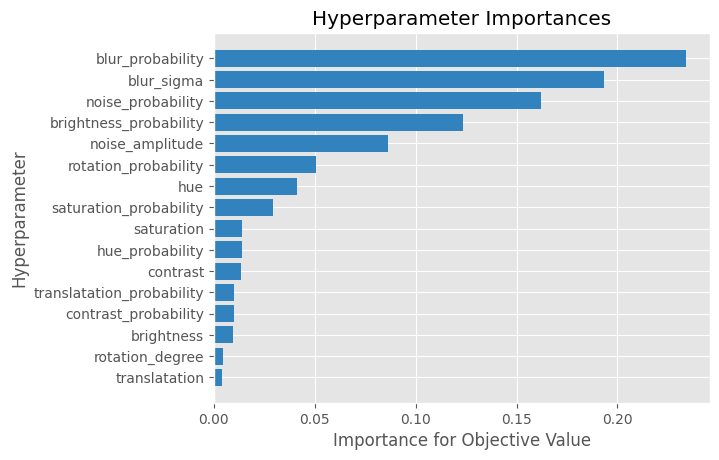

In [20]:
optuna.visualization.matplotlib.plot_param_importances(study)

/tmp/ipykernel_120336/3203836443.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, params=[param])
/tmp/ipykernel_120336/3203836443.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, params=[param])
/tmp/ipykernel_120336/3203836443.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, params=[param])
/tmp/ipykernel_120336/3203836443.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, params=[param])
/tmp/ipykernel_120336/3203836443.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The inte

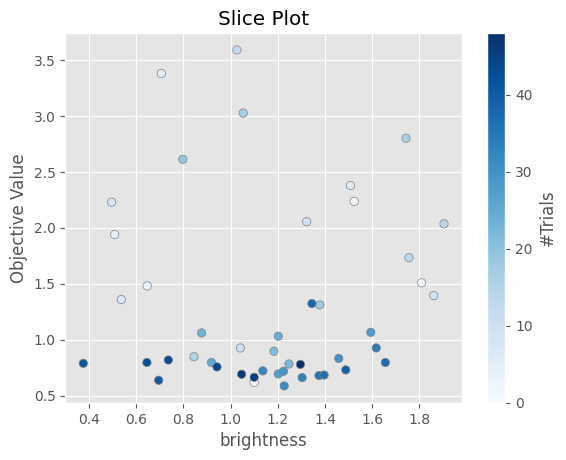

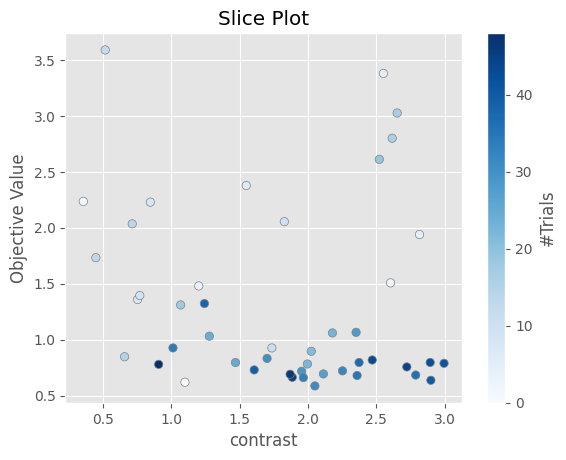

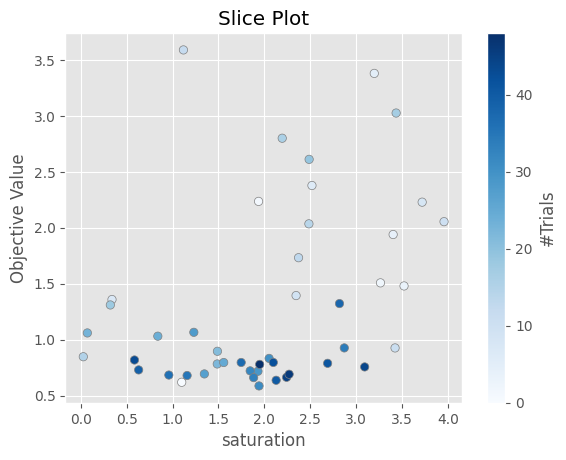

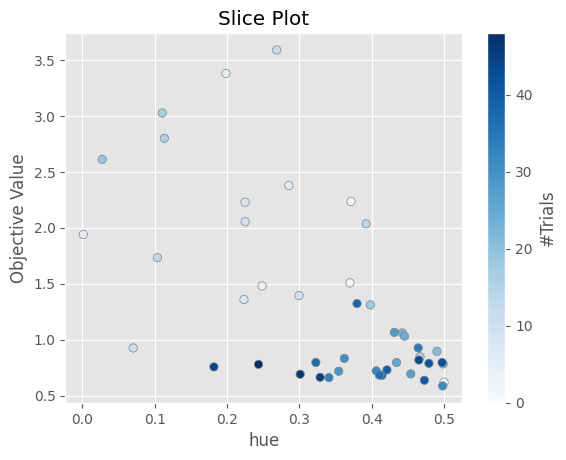

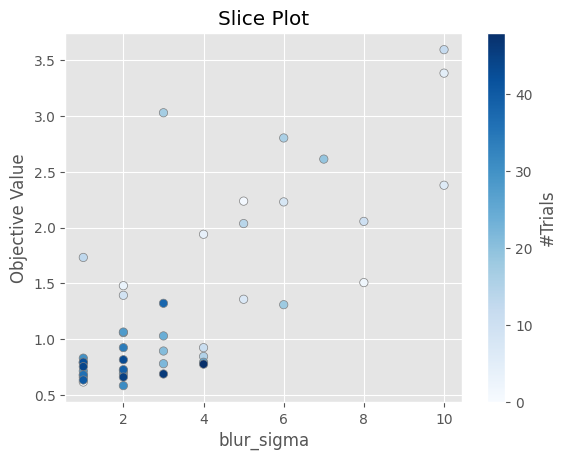

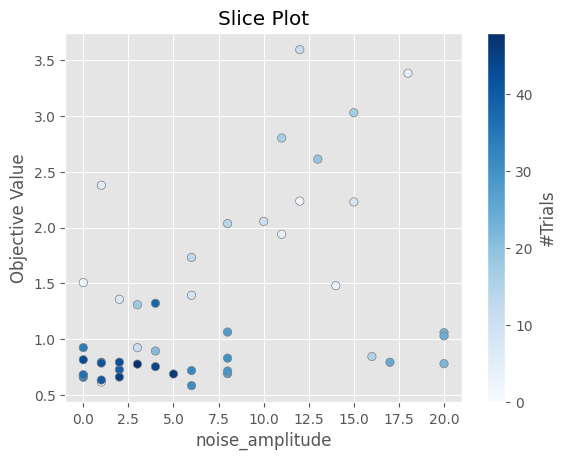

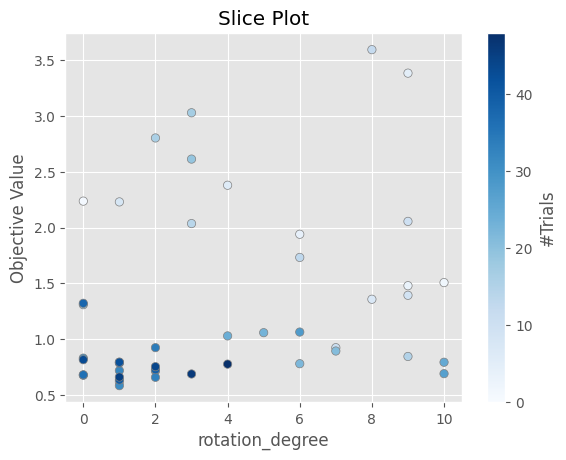

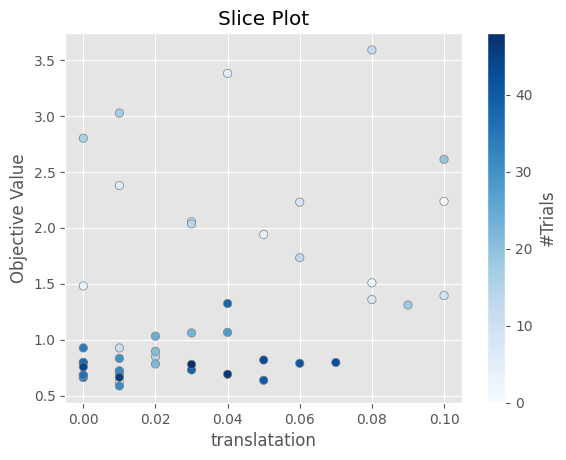

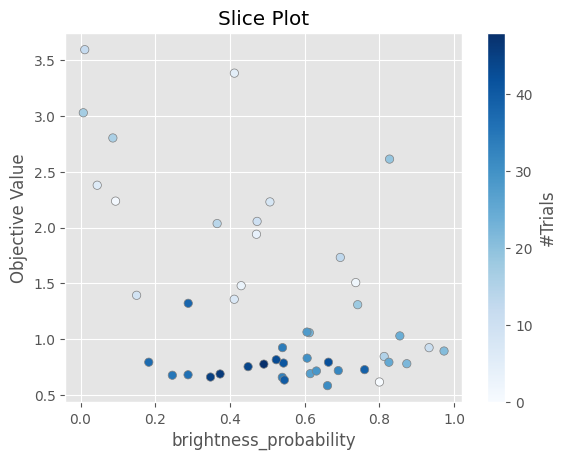

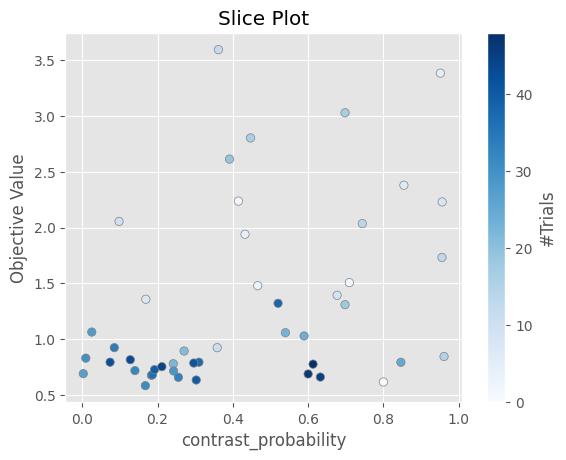

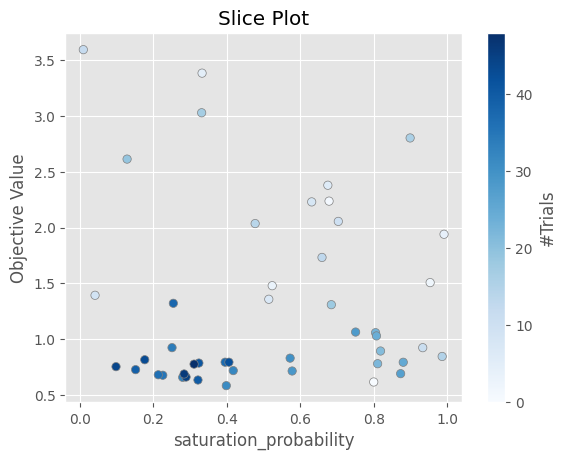

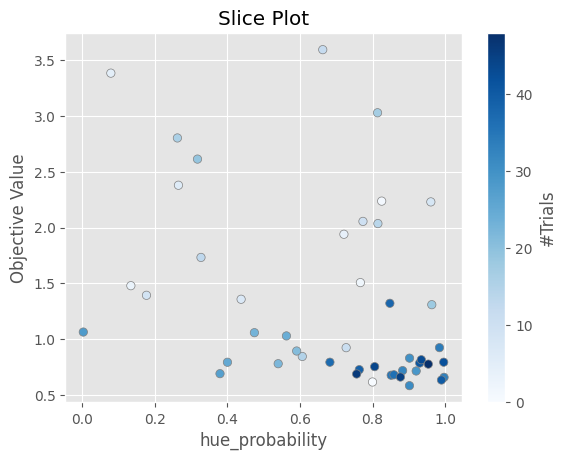

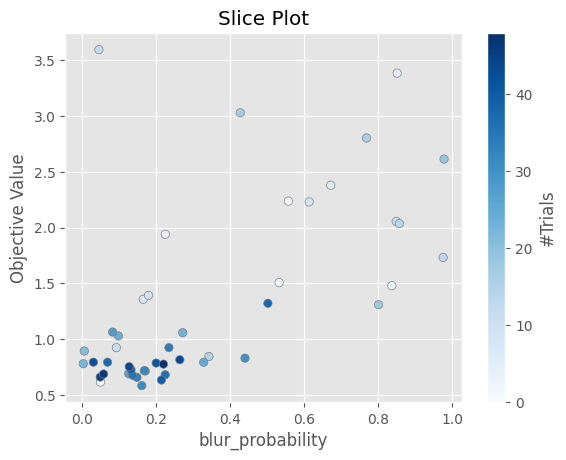

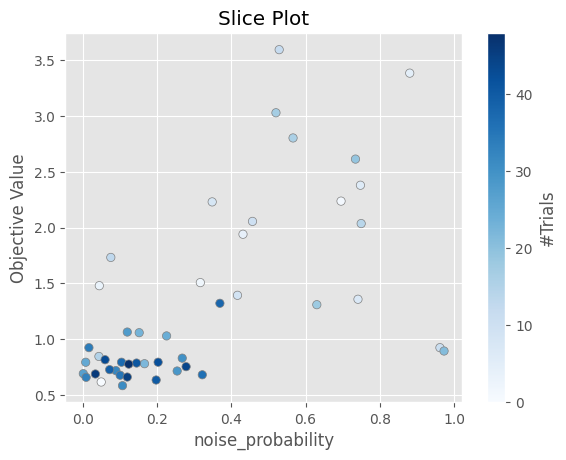

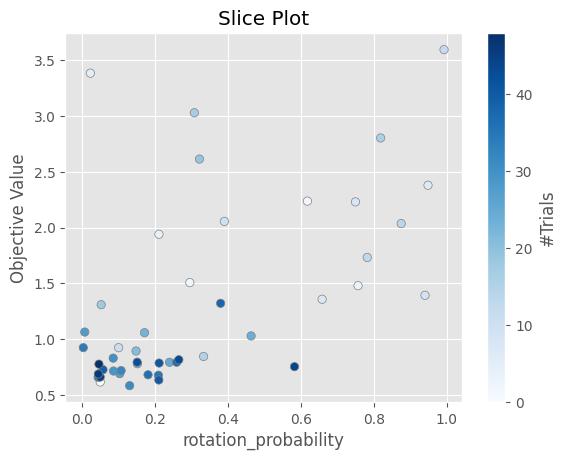

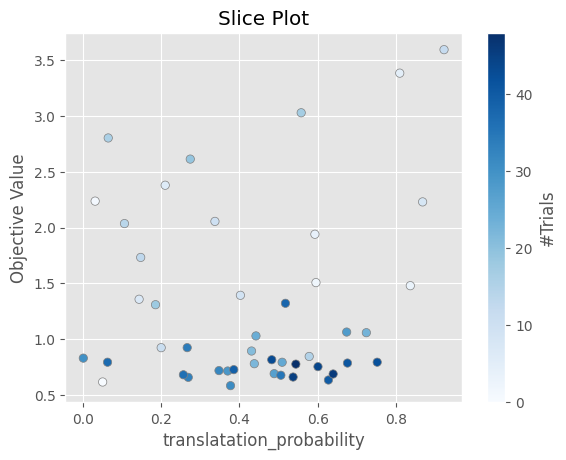

In [14]:
for param in study.trials[0].params:
    optuna.visualization.matplotlib.plot_slice(study, params=[param])

/tmp/ipykernel_120336/1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

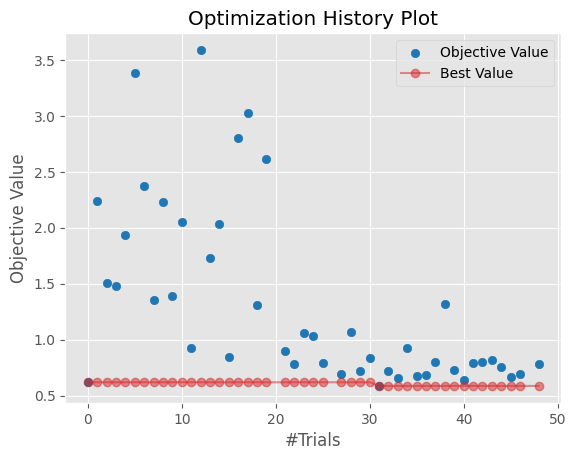

In [15]:
optuna.visualization.matplotlib.plot_optimization_history(study)

/tmp/ipykernel_83725/2140463885.py:1: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_intermediate_values(study)


<AxesSubplot:title={'center':'Intermediate Values Plot'}, xlabel='Step', ylabel='Intermediate Value'>

/home/r08942088/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


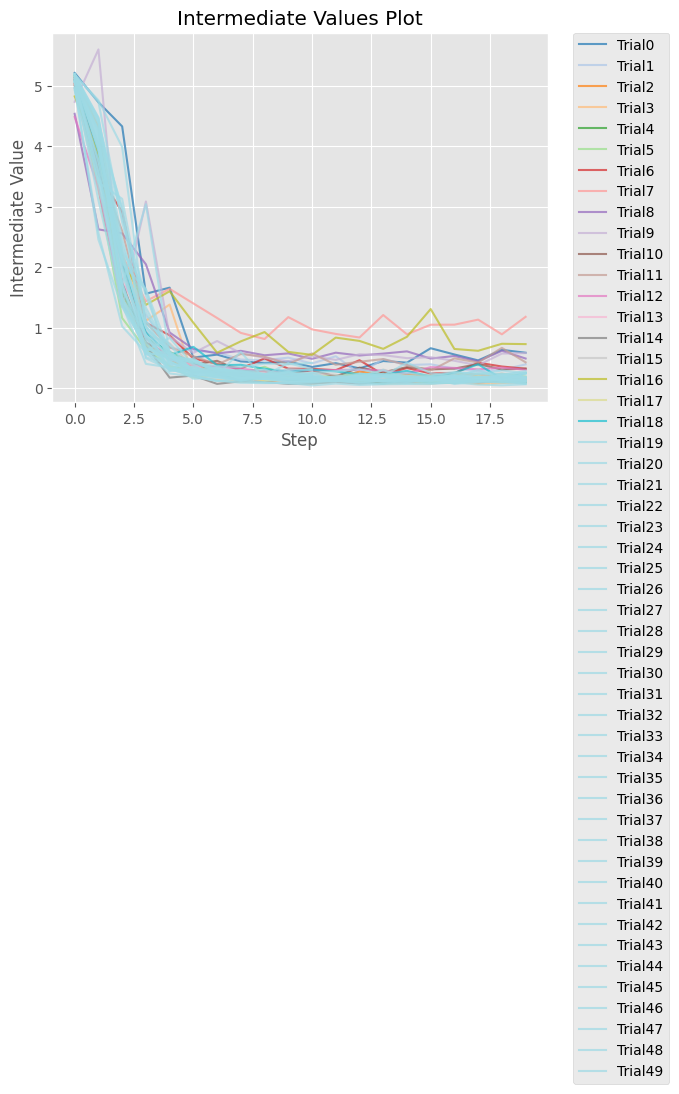

In [22]:
optuna.visualization.matplotlib.plot_intermediate_values(study)

In [36]:
torch.save(loaded_study.best_params, f"optuna/best_params-{times}.pt")
loaded_study.best_params

{'blur_probability': 0.16774473059106249,
 'blur_sigma': 2,
 'brightness': 1.4235279366381415,
 'brightness_probability': 0.3176921664889572,
 'contrast': 0.7187927173932609,
 'contrast_probability': 0.3833749247130268,
 'hue': 0.4105569446666081,
 'hue_probability': 0.8903004859359391,
 'noise_amplitude': 2,
 'noise_probability': 0.19332977479147118,
 'rotation_degree': 2,
 'rotation_probability': 0.029515916084843136,
 'saturation': 1.6389445614457903,
 'saturation_probability': 0.16965246023298108,
 'translatation': 0.07,
 'translatation_probability': 0.001097251541102912}

In [16]:
# threshold filter
from optuna.samplers._tpe import *
from optuna import distributions
import numpy as np
import math

def default_gamma(x: int) -> int:

    return min(int(np.ceil(0.1 * x)), 25)


def default_weights(x: int) -> np.ndarray:

    if x == 0:
        return np.asarray([])
    elif x < 25:
        return np.ones(x)
    else:
        ramp = np.linspace(1.0 / x, 1.0, num=x - 25)
        flat = np.ones(25)
        return np.concatenate([ramp, flat], axis=0)

def meanOfBelow(study, param_name, log=False):
    param_distribution = study.trials[-1].distributions[param_name]
    _parzen_estimator_parameters = parzen_estimator._ParzenEstimatorParameters(
        True,
        1.0,
        True,
        False,
        default_weights,
        False,
    )
    values, scores = sampler._get_observation_pairs(
        study,
        [param_name],
        False,
        False,
    )
    n = len(scores)

    indices_below, indices_above = sampler._split_observation_pairs(scores, default_gamma(n))
    # # `None` items are intentionally converted to `nan` and then filtered out.
    # # For `nan` conversion, the dtype must be float.
    config_values = {k: np.asarray(v, dtype=float) for k, v in values.items()}
    below = sampler._build_observation_dict(config_values, indices_below)
    if log:
        print(below)
    # mpe_below = parzen_estimator._ParzenEstimator(
    #     below, {param_name: param_distribution}, _parzen_estimator_parameters
    # )
    # samples_below = mpe_below.sample(np.random.RandomState(None), 24)
    # log_likelihoods_below = mpe_below.log_pdf(samples_below)

    # return samples_below[param_name].mean()
    return below[param_name].mean()

def gamma_half(x: int) -> int:

    return min(int(np.ceil(0.5 * x)), 25)

def boundsOfBelow(study, param_name, log=False):
    values, scores = sampler._get_observation_pairs(
        study,
        [param_name],
        False,
        False,
    )
    n = len(scores)

    indices_below, indices_above = sampler._split_observation_pairs(scores, gamma_half(n))
    config_values = {k: np.asarray(v, dtype=float) for k, v in values.items()}
    below = sampler._build_observation_dict(config_values, indices_below)
    if log:
        print(below)
    upperBound = round(max(below[param_name]),2)
    lowerBound = round(min(below[param_name]),2)
    return lowerBound, upperBound


In [17]:
# params_p = ['brightness_probability',
#     'contrast_probability',
#     'saturation_probability',
#     'hue_probability',
#     'blur_probability',
#     'noise_probability',
#     'rotation_probability',
#     'translatation_probability'
# ]
# params_v = ['brightness',
#     'contrast',
#     'saturation',
#     'hue',
#     'blur_sigma',
#     'noise_amplitude',
#     'rotation_degree',
#     'translatation',
# ]

# means = {p:meanOfBelow(loaded_study, p) for p in params_p}
# bounds = {p:boundsOfBelow(loaded_study, p) for p in params_v}
# means, bounds

params_p = ['brightness_probability',
    'contrast_probability',
    'saturation_probability',
    'hue_probability',
    'blur_probability',
    'noise_probability',
    'rotation_probability',
    'translatation_probability'
]
params_v = ['brightness',
    'contrast',
    'saturation',
    'hue',
    'blur_sigma',
    'noise_amplitude',
    'rotation_degree',
    'translatation',
]
means = {p:meanOfBelow(study, p) for p in params_p}
bounds = {p:boundsOfBelow(study, p) for p in params_v}
means, bounds

({'brightness_probability': 0.5789018117849432,
  'contrast_probability': 0.4316285640889409,
  'saturation_probability': 0.4178759003876773,
  'hue_probability': 0.9132851155802172,
  'blur_probability': 0.12473221303072872,
  'noise_probability': 0.09695751848907327,
  'rotation_probability': 0.09713459984813191,
  'translatation_probability': 0.37219399056130376},
 {'brightness': (0.38, 1.66),
  'contrast': (0.66, 2.99),
  'saturation': (0.03, 3.43),
  'hue': (0.07, 0.5),
  'blur_sigma': (1.0, 4.0),
  'noise_amplitude': (0.0, 20.0),
  'rotation_degree': (0.0, 10.0),
  'translatation': (0.0, 0.07)})

/tmp/ipykernel_227279/1033336482.py:6: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(loaded_study)


{'blur_probability': 0.16774473059106249,
 'blur_sigma': 2,
 'brightness': 1.4235279366381415,
 'brightness_probability': 0.3176921664889572,
 'contrast': 0.7187927173932609,
 'contrast_probability': 0.3833749247130268,
 'hue': 0.4105569446666081,
 'hue_probability': 0.8903004859359391,
 'noise_amplitude': 2,
 'noise_probability': 0.19332977479147118,
 'rotation_degree': 2,
 'rotation_probability': 0.029515916084843136,
 'saturation': 1.6389445614457903,
 'saturation_probability': 0.16965246023298108,
 'translatation': 0.07,
 'translatation_probability': 0.001097251541102912}

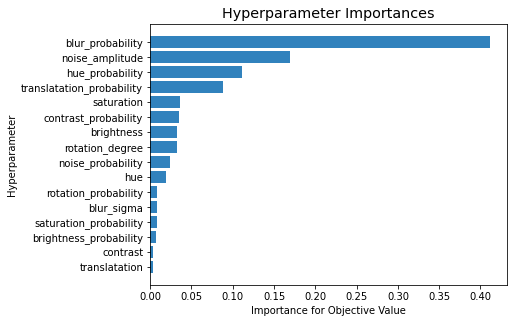

In [1]:
import optuna
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6.4, 4.8]
times = "reorder-first-50"
loaded_study = optuna.load_study(study_name=f"augmentation-first", storage=f"sqlite:///optuna/augmentation-{times}.db")
optuna.visualization.matplotlib.plot_param_importances(loaded_study)
loaded_study.best_params

/tmp/ipykernel_227279/4148709342.py:158: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axcb = fig.colorbar(sc, ax=axs)
/tmp/ipykernel_227279/4148709342.py:158: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axcb = fig.colorbar(sc, ax=axs)


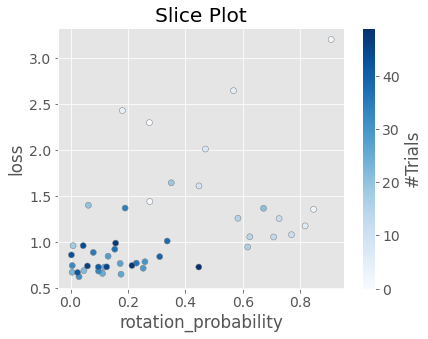

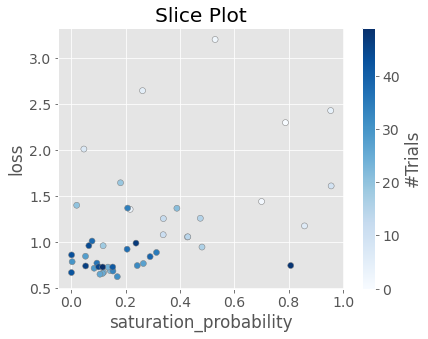

In [3]:
import math
from typing import Callable
from typing import cast
from typing import List
from typing import Optional
from typing import Tuple
from typing import Union

from optuna._experimental import experimental
from optuna.logging import get_logger
from optuna.study import Study
from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from optuna.visualization._utils import _check_plot_args
from optuna.visualization.matplotlib._matplotlib_imports import _imports
from optuna.visualization.matplotlib._utils import _is_log_scale
from optuna.visualization.matplotlib._utils import _is_numerical


if _imports.is_successful():
    from optuna.visualization.matplotlib._matplotlib_imports import Axes
    from optuna.visualization.matplotlib._matplotlib_imports import Colormap
    from optuna.visualization.matplotlib._matplotlib_imports import matplotlib
    from optuna.visualization.matplotlib._matplotlib_imports import PathCollection
    from optuna.visualization.matplotlib._matplotlib_imports import plt

_logger = get_logger(__name__)


@experimental("2.2.0")
def plot_slice(
    study: Study,
    params: Optional[List[str]] = None,
    *,
    target: Optional[Callable[[FrozenTrial], float]] = None,
    target_name: str = "Objective Value",
) -> "Axes":
    """Plot the parameter relationship as slice plot in a study with Matplotlib.

    .. seealso::
        Please refer to :func:`optuna.visualization.plot_slice` for an example.

    Example:

        The following code snippet shows how to plot the parameter relationship as slice plot.

        .. plot::

            import optuna


            def objective(trial):
                x = trial.suggest_float("x", -100, 100)
                y = trial.suggest_categorical("y", [-1, 0, 1])
                return x ** 2 + y


            sampler = optuna.samplers.TPESampler(seed=10)
            study = optuna.create_study(sampler=sampler)
            study.optimize(objective, n_trials=10)

            optuna.visualization.matplotlib.plot_slice(study, params=["x", "y"])

    Args:
        study:
            A :class:`~optuna.study.Study` object whose trials are plotted for their target values.
        params:
            Parameter list to visualize. The default is all parameters.
        target:
            A function to specify the value to display. If it is :obj:`None` and ``study`` is being
            used for single-objective optimization, the objective values are plotted.

            .. note::
                Specify this argument if ``study`` is being used for multi-objective optimization.
        target_name:
            Target's name to display on the axis label.


    Returns:
        A :class:`matplotlib.axes.Axes` object.

    Raises:
        :exc:`ValueError`:
            If ``target`` is :obj:`None` and ``study`` is being used for multi-objective
            optimization.
    """

    _imports.check()
    _check_plot_args(study, target, target_name)
    return _get_slice_plot(study, params, target, target_name)



def _get_slice_plot(
    study: Study,
    params: Optional[List[str]] = None,
    target: Optional[Callable[[FrozenTrial], float]] = None,
    target_name: str = "Objective Value",
) -> "Axes":

    # Calculate basic numbers for plotting.
    trials = [trial for trial in study.trials if trial.state == TrialState.COMPLETE]

    if len(trials) == 0:
        _logger.warning("Your study does not have any completed trials.")
        _, ax = plt.subplots()
        return ax

    all_params = {p_name for t in trials for p_name in t.params.keys()}
    if params is None:
        sorted_params = sorted(all_params)
    else:
        for input_p_name in params:
            if input_p_name not in all_params:
                raise ValueError("Parameter {} does not exist in your study.".format(input_p_name))
        sorted_params = sorted(set(params))

    n_params = len(sorted_params)

    # Set up the graph style.
    cmap = plt.get_cmap("Blues")
    padding_ratio = 0.05
    plt.style.use("ggplot")  # Use ggplot style sheet for similar outputs to plotly.
    plt.rcParams.update({'font.size': 14}) 
    
    # Prepare data.
    if target is None:
        obj_values = [cast(float, t.value+0.5) for t in trials]
    else:
        obj_values = [target(t) for t in trials]

    if n_params == 1:
        # Set up the graph style.
        fig, axs = plt.subplots()
        axs.set_title("Slice Plot")

        # Draw a scatter plot.
        sc = _generate_slice_subplot(
            trials, sorted_params[0], axs, cmap, padding_ratio, obj_values, target_name
        )
    else:
        # Set up the graph style.
        min_figwidth = matplotlib.rcParams["figure.figsize"][0] / 2
        fighight = matplotlib.rcParams["figure.figsize"][1]
        # Ensure that each subplot has a minimum width without relying on auto-sizing.
        fig, axs = plt.subplots(
            1, n_params, sharey=True, figsize=(min_figwidth * n_params, fighight)
        )
        fig.suptitle("Slice Plot")

        # Draw scatter plots.
        for i, param in enumerate(sorted_params):
            ax = axs[i]
            sc = _generate_slice_subplot(
                trials, param, ax, cmap, padding_ratio, obj_values, target_name
            )

    axcb = fig.colorbar(sc, ax=axs)
    axcb.set_label("#Trials")

    return axs


def _generate_slice_subplot(
    trials: List[FrozenTrial],
    param: str,
    ax: "Axes",
    cmap: "Colormap",
    padding_ratio: float,
    obj_values: List[Union[int, float]],
    target_name: str,
) -> "PathCollection":
    x_values = []
    y_values = []
    trial_numbers = []
    scale = None
    for t, obj_v in zip(trials, obj_values):
        if param in t.params:
            x_values.append(t.params[param])
            y_values.append(obj_v)
            trial_numbers.append(t.number)
    ax.set(xlabel=param, ylabel=target_name)
    if _is_log_scale(trials, param):
        ax.set_xscale("log")
        scale = "log"
    elif not _is_numerical(trials, param):
        x_values = [str(x) for x in x_values]
        scale = "categorical"
    xlim = _calc_lim_with_padding(x_values, padding_ratio, scale)
    ax.set_xlim(xlim[0], xlim[1])
    sc = ax.scatter(x_values, y_values, c=trial_numbers, cmap=cmap, edgecolors="grey")
    ax.label_outer()

    return sc


def _calc_lim_with_padding(
    values: List[Union[int, float]], padding_ratio: float, scale: Optional[str] = None
) -> Tuple[Union[int, float], Union[int, float]]:
    value_max = max(values)
    value_min = min(values)
    if scale == "log":
        padding = (math.log10(value_max) - math.log10(value_min)) * padding_ratio
        return (
            math.pow(10, math.log10(value_min) - padding),
            math.pow(10, math.log10(value_max) + padding),
        )
    elif scale == "categorical":
        width = len(set(values)) - 1
        padding = width * padding_ratio
        return -padding, width + padding
    else:
        padding = (value_max - value_min) * padding_ratio
        return value_min - padding, value_max + padding

plt.rcParams.update({'font.size': 14}) 
params = ["rotation_probability", "saturation_probability"]
for param in params:
    _get_slice_plot(loaded_study, params=[param], target_name="loss")
    plt.savefig(f"optuna/{times}/{times}-slice-{param}.pdf")

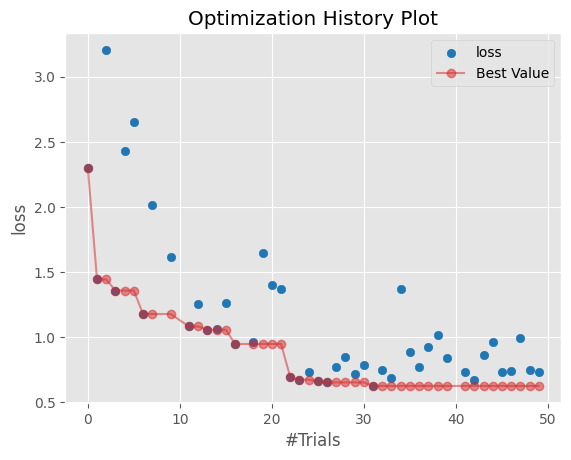

In [54]:
from typing import Callable
from typing import cast
from typing import Optional

import numpy as np

from optuna._experimental import experimental
from optuna.logging import get_logger
from optuna.study import Study
from optuna.study import StudyDirection
from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from optuna.visualization._utils import _check_plot_args
from optuna.visualization.matplotlib._matplotlib_imports import _imports


if _imports.is_successful():
    from optuna.visualization.matplotlib._matplotlib_imports import Axes
    from optuna.visualization.matplotlib._matplotlib_imports import plt

_logger = get_logger(__name__)


@experimental("2.2.0")
def plot_optimization_history(
    study: Study,
    *,
    target: Optional[Callable[[FrozenTrial], float]] = None,
    target_name: str = "Objective Value",
) -> "Axes":
    """Plot optimization history of all trials in a study with Matplotlib.

    .. seealso::
        Please refer to :func:`optuna.visualization.plot_optimization_history` for an example.

    Example:

        The following code snippet shows how to plot optimization history.

        .. plot::

            import optuna


            def objective(trial):
                x = trial.suggest_float("x", -100, 100)
                y = trial.suggest_categorical("y", [-1, 0, 1])
                return x ** 2 + y

            sampler = optuna.samplers.TPESampler(seed=10)
            study = optuna.create_study(sampler=sampler)
            study.optimize(objective, n_trials=10)

            optuna.visualization.matplotlib.plot_optimization_history(study)

    Args:
        study:
            A :class:`~optuna.study.Study` object whose trials are plotted for their target values.
        target:
            A function to specify the value to display. If it is :obj:`None` and ``study`` is being
            used for single-objective optimization, the objective values are plotted.

            .. note::
                Specify this argument if ``study`` is being used for multi-objective optimization.
        target_name:
            Target's name to display on the axis label and the legend.

    Returns:
        A :class:`matplotlib.axes.Axes` object.

    Raises:
        :exc:`ValueError`:
            If ``target`` is :obj:`None` and ``study`` is being used for multi-objective
            optimization.
    """

    _imports.check()
    _check_plot_args(study, target, target_name)
    return _get_optimization_history_plot(study, target, target_name)



def _get_optimization_history_plot(
    study: Study,
    target: Optional[Callable[[FrozenTrial], float]],
    target_name: str,
) -> "Axes":

    # Set up the graph style.
    plt.style.use("ggplot")  # Use ggplot style sheet for similar outputs to plotly.
    _, ax = plt.subplots()
    ax.set_title("Optimization History Plot")
    ax.set_xlabel("#Trials")
    ax.set_ylabel(target_name)
    cmap = plt.get_cmap("tab10")  # Use tab10 colormap for similar outputs to plotly.

    # Prepare data for plotting.
    trials = [t for t in study.trials if t.state == TrialState.COMPLETE]

    if len(trials) == 0:
        _logger.warning("Study instance does not contain trials.")
        return ax

    # Draw a scatter plot and a line plot.
    if target is None:
        if study.direction == StudyDirection.MINIMIZE:
            best_values = np.minimum.accumulate([cast(float, t.value+0.5) for t in trials])
        else:
            best_values = np.maximum.accumulate([cast(float, t.value) for t in trials])
        ax.scatter(
            x=[t.number for t in trials],
            y=[t.value+0.5 for t in trials],
            color=cmap(0),
            alpha=1,
            label=target_name,
        )
        ax.plot(
            [t.number for t in trials],
            best_values,
            marker="o",
            color=cmap(3),
            alpha=0.5,
            label="Best Value",
        )

        ax.legend()
    else:
        ax.scatter(
            x=[t.number for t in trials],
            y=[target(t) for t in trials],
            color=cmap(0),
            alpha=1,
            label=target_name,
        )

    return ax


_get_optimization_history_plot(loaded_study, target=None, target_name="loss")
plt.savefig(f"optuna/{times}/{times}-history.pdf")


/tmp/ipykernel_120336/510265888.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(loaded_study, params=[param], target_name="loss")
/tmp/ipykernel_120336/510265888.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(loaded_study, params=[param], target_name="loss")
/tmp/ipykernel_120336/510265888.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(loaded_study, params=[param], target_name="loss")
/tmp/ipykernel_120336/510265888.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(loaded_study, params=[param], target_name="loss")
/tmp/ipykernel_1

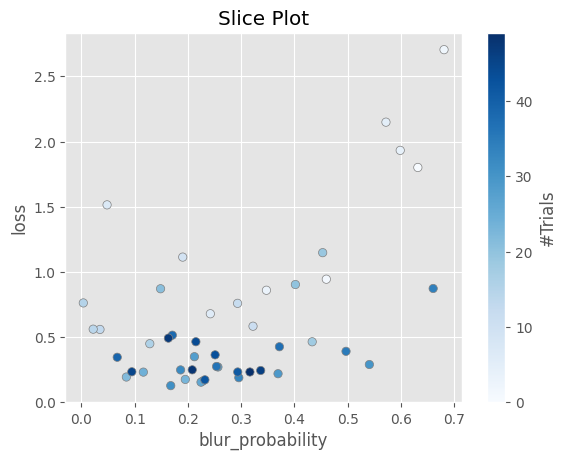

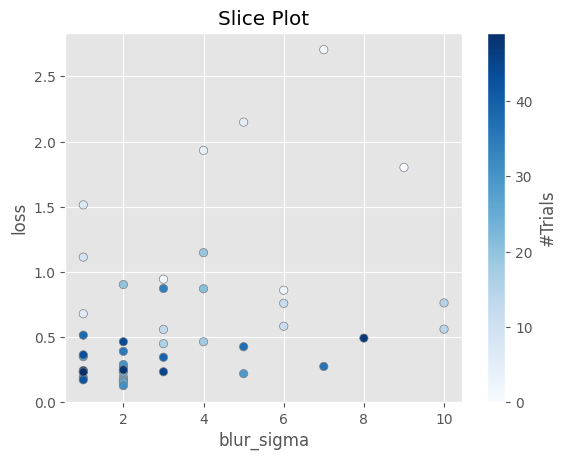

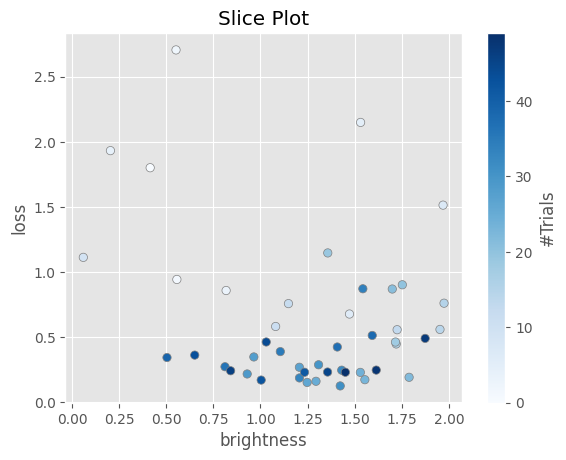

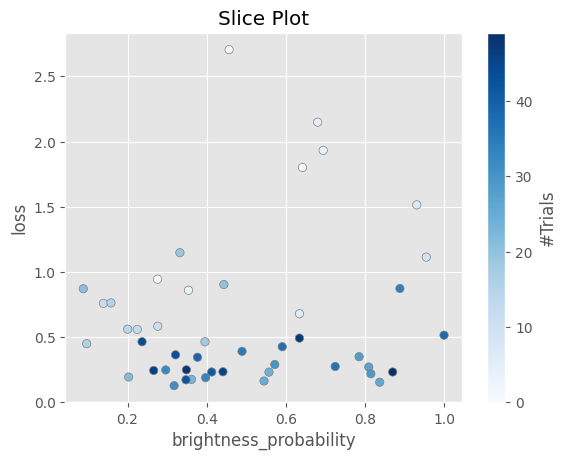

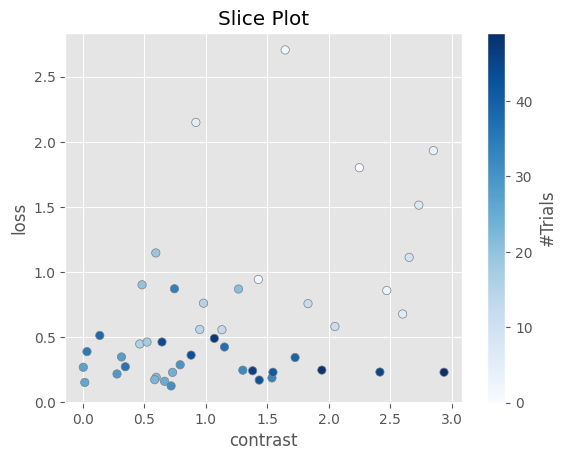

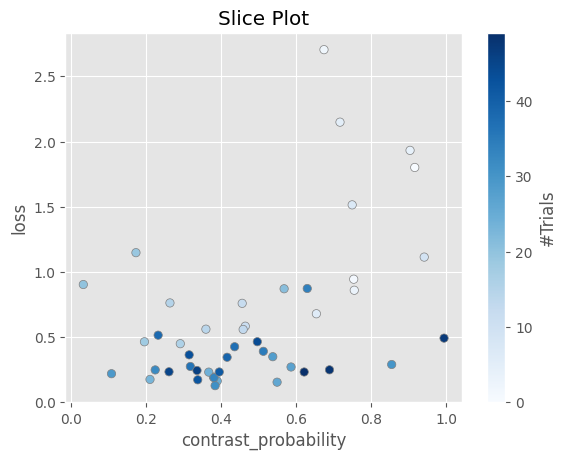

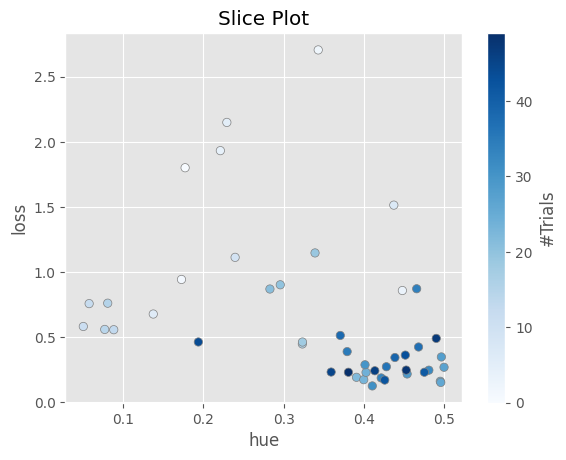

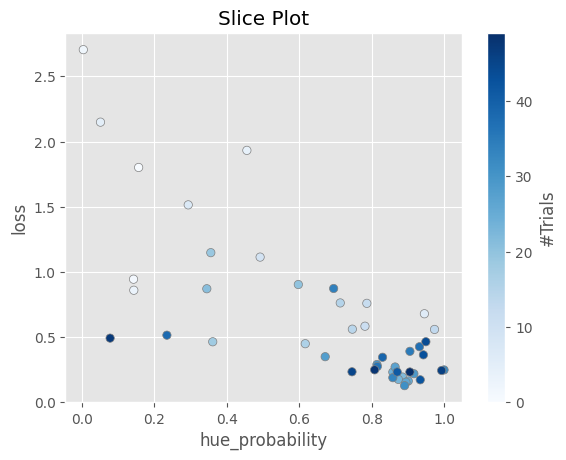

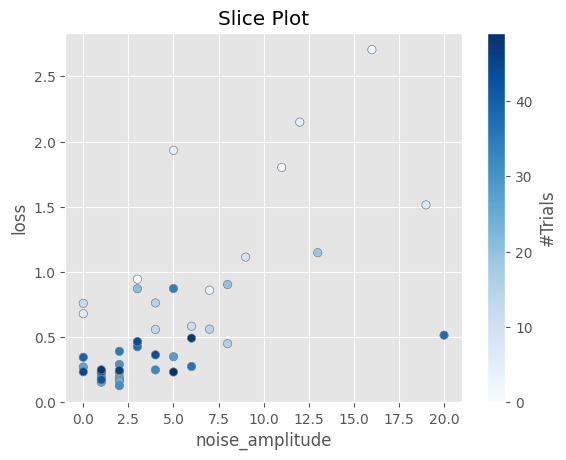

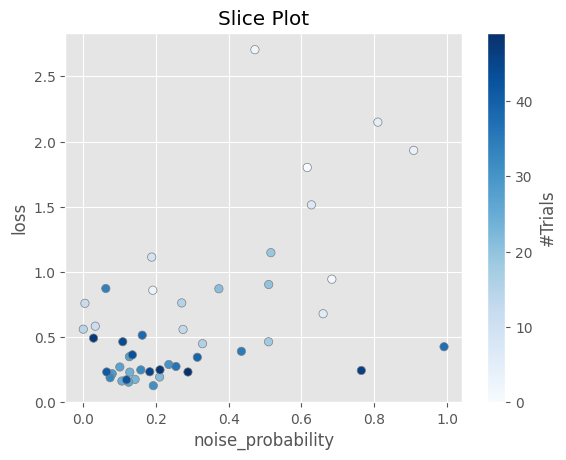

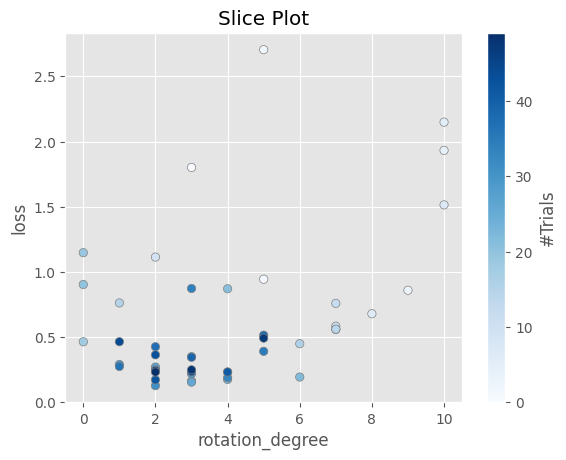

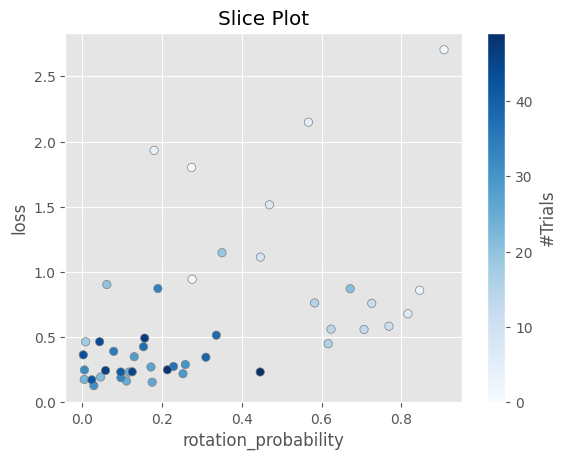

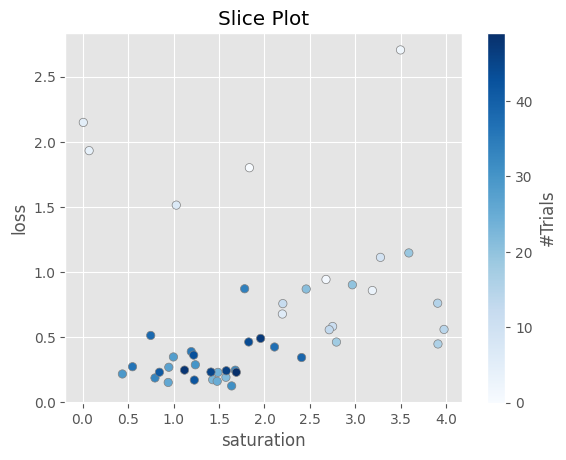

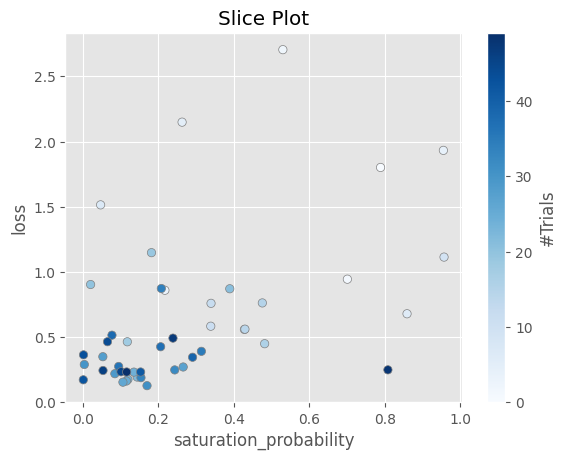

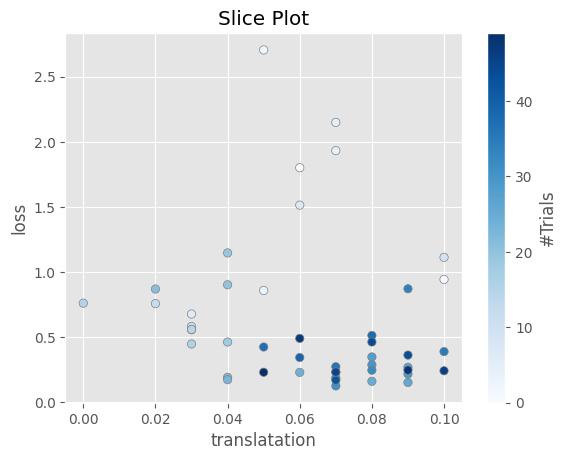

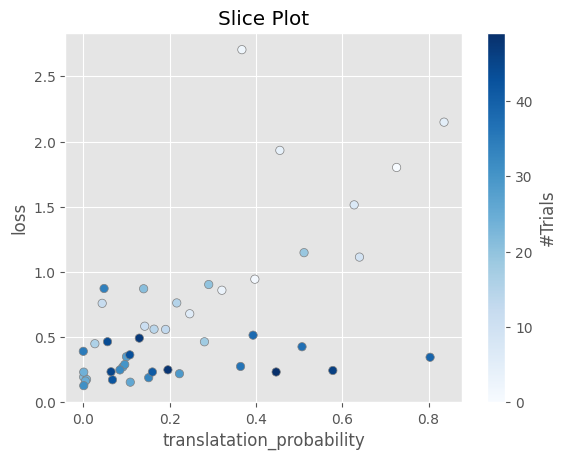

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6.4, 4.8]
for param in loaded_study.trials[0].params:
    optuna.visualization.matplotlib.plot_slice(loaded_study, params=[param], target_name="loss")
    # plt.savefig(f"optuna/{times}/{times}-slice-{param}.pdf")

/tmp/ipykernel_120336/2234948094.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_optimization_history(loaded_study, target_name="loss")


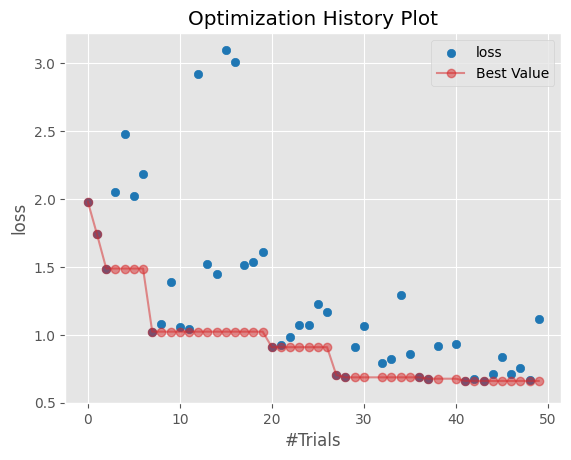

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6.4, 4.8]
ax = optuna.visualization.matplotlib.plot_optimization_history(loaded_study, target_name="loss")
ax.set_ylim(ymin=0.5)
# plt.show()
plt.savefig(f"optuna/{times}/{times}-history.pdf")

/tmp/ipykernel_78953/635703457.py:3: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_intermediate_values(loaded_study)
/tmp/ipykernel_78953/635703457.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(f"optuna/{times}/{times}-intermediate.jpg")
/home/r08942088/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


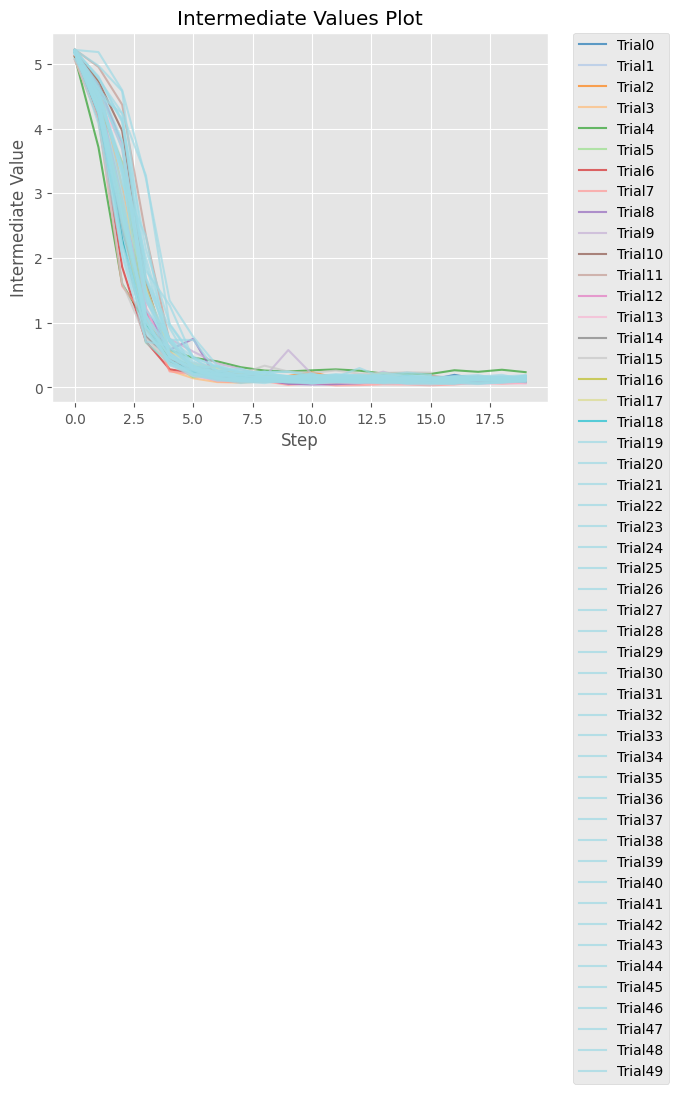

In [68]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6.4,4.8)
optuna.visualization.matplotlib.plot_intermediate_values(loaded_study)
plt.savefig(f"optuna/{times}/{times}-intermediate.jpg")

/tmp/ipykernel_78953/2152180007.py:7: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study_full, study_second_100, study_third])


<AxesSubplot:title={'center':'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

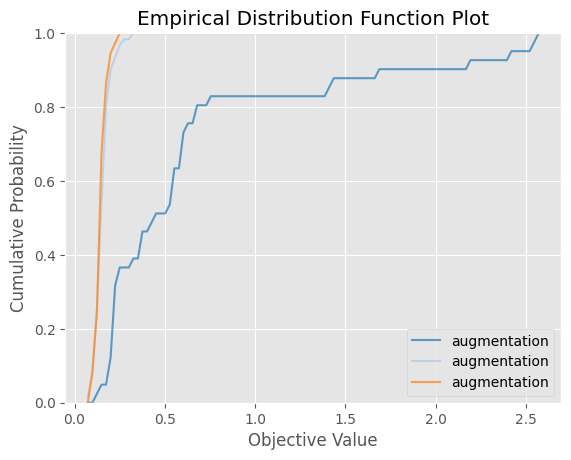

In [73]:
import optuna
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6.4, 4.8]
study_full = optuna.load_study(study_name="augmentation", storage=f"sqlite:///optuna/augmentation-full.db")
study_second_100 = optuna.load_study(study_name="augmentation", storage=f"sqlite:///optuna/augmentation-second-100.db")
study_third = optuna.load_study(study_name="augmentation", storage=f"sqlite:///optuna/augmentation-third.db")
optuna.visualization.matplotlib.plot_edf([study_full, study_second_100, study_third])
